### LSTM inference, model which was build on Panasonic dataset are testing on LG dataset

In [31]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
import os

In [60]:
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Voltage Average', 'Current Average', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
SEQUENCE_LENGTH = 20 

In [33]:
# SoCLSTM Model
class SoCLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SoCLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [34]:
def load_lstm_model(model_path, input_size, hidden_size, num_layers):
    model = SoCLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).type(torch.float32)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model_state_dict'])
    model.eval()
    return model

In [61]:
hidden_size = 128
num_layers = 4
input_size = len(FEATURE_COLS)

In [62]:
model_path = "../training_and_testing/for_panasonic_data/soc_lstm_model.pth"
model = load_lstm_model(model_path, input_size, hidden_size, num_layers)

In [64]:
def collect_data(cycle_name):
    results = defaultdict(dict)

    base_path = '../datasets/LG_dataset/LG_HG2_processed'


    temp_folders = ['0degC', '10degC', '25degC', '40degC', 'n10degC', 'n20degC']


    for temp_folder in temp_folders:
        folder_path = os.path.join(base_path, temp_folder)

        for file in os.listdir(folder_path):
            if cycle_name in file and file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                

                test_df = pd.read_csv(file_path)
                test_df['Power [W]'] = test_df['Voltage [V]'] * test_df['Current [A]']
                
                rolling_window = 500
                test_df['Voltage Average'] = test_df['Voltage [V]'].rolling(rolling_window).mean()
                test_df['Current Average'] = test_df['Current [A]'].rolling(rolling_window).mean()
                test_df['SourceFile'] = file
                

                scaler = StandardScaler()
                test_df[FEATURE_COLS] = scaler.fit_transform(test_df[FEATURE_COLS])
                

                test_tensor = torch.tensor(test_df[FEATURE_COLS].values, dtype=torch.float32)
                test_labels = torch.tensor(test_df[LABEL_COL].values, dtype=torch.float32)
                

                results[temp_folder][file] = {
                    'dataframe': test_df,
                    'tensor': test_tensor,
                    'labels': test_labels,
                    'scaler': scaler
                }
    return results

In [40]:
def evaluate_and_plot(model, results):
    metrics = {}
    
    for temp_folder, files_data in results.items():
        metrics[temp_folder] = {}
        
        for file_name, file_data in files_data.items():
            test_df = file_data['dataframe']
            test_tensor = file_data['tensor']
            test_labels = file_data['labels']
            
            # Create sequences for inference
            sequences = []
            labels = []
            times = []
            
            for i in range(len(test_tensor) - SEQUENCE_LENGTH):
                sequences.append(test_tensor[i:i+SEQUENCE_LENGTH])
                labels.append(test_labels[i+SEQUENCE_LENGTH-1])  # Last label in sequence
                times.append(test_df['Time [s]'].values[i+SEQUENCE_LENGTH-1])
            
            if not sequences:
                continue
                
            # Convert to tensor
            sequences_tensor = torch.stack(sequences)
            labels_tensor = torch.stack(labels)
            
            with torch.no_grad():
                predictions = model(sequences_tensor)
                predictions = predictions.cpu().view(-1).numpy()
                labels = labels_tensor.cpu().view(-1).numpy()
            
            times = np.array(times)
            prediction_np = np.array(predictions)
            test_label_np = np.array(labels)

            mask = ~np.isnan(test_label_np) & ~np.isnan(prediction_np)
            test_label_clean = test_label_np[mask]
            prediction_clean = prediction_np[mask]
            times_clean = times[mask]
            
            mse = mean_squared_error(test_label_clean, prediction_clean)
            mae = mean_absolute_error(test_label_clean, prediction_clean)
            stddev = np.std(test_label_clean - prediction_clean)
            
            metrics[temp_folder][file_name] = {
                'MSE': mse,
                'MAE': mae,
                'StdDev': stddev
            }
            
            plt.figure(figsize=(12, 6))
            plt.plot(times_clean, test_label_clean, label='True SOC', color='blue')
            plt.plot(times_clean, prediction_clean, label='Predicted SOC', color='red')
            plt.title(f'Temperature and cycle: {temp_folder} and {file_name}')
            plt.xlabel('Time [s]')
            plt.ylabel('SOC')
            plt.legend()
            plt.show()
            
            print(f"\nMetrics for {temp_folder}/{file_name}:")
            print(f"Test MSE: {mse:.6f}")
            print(f"Test MAE: {mae:.6f}")
            print(f"Test StdDev: {stddev:.6f}")
    
    return metrics

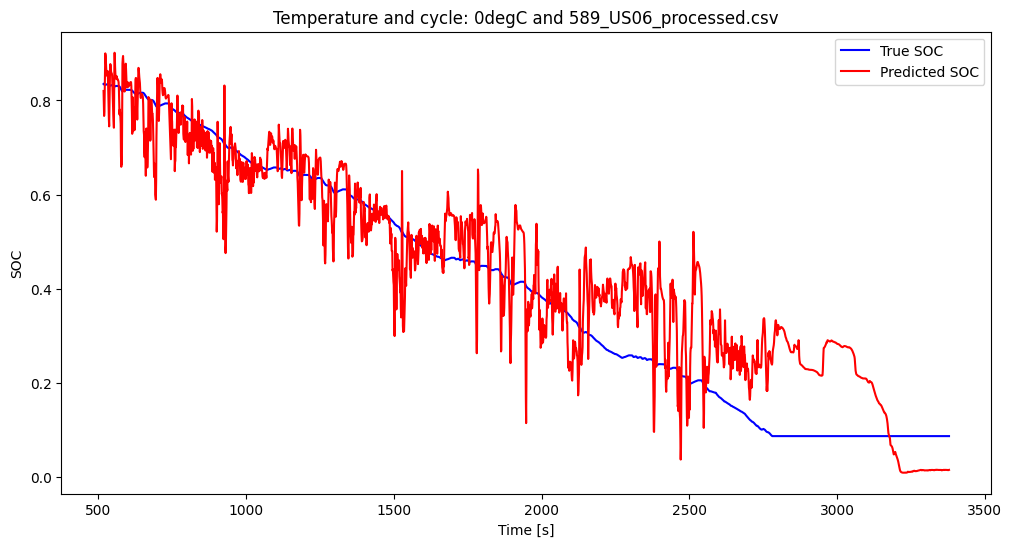


Metrics for 0degC/589_US06_processed.csv:
Test MSE: 0.010594
Test MAE: 0.082528
Test StdDev: 0.095335


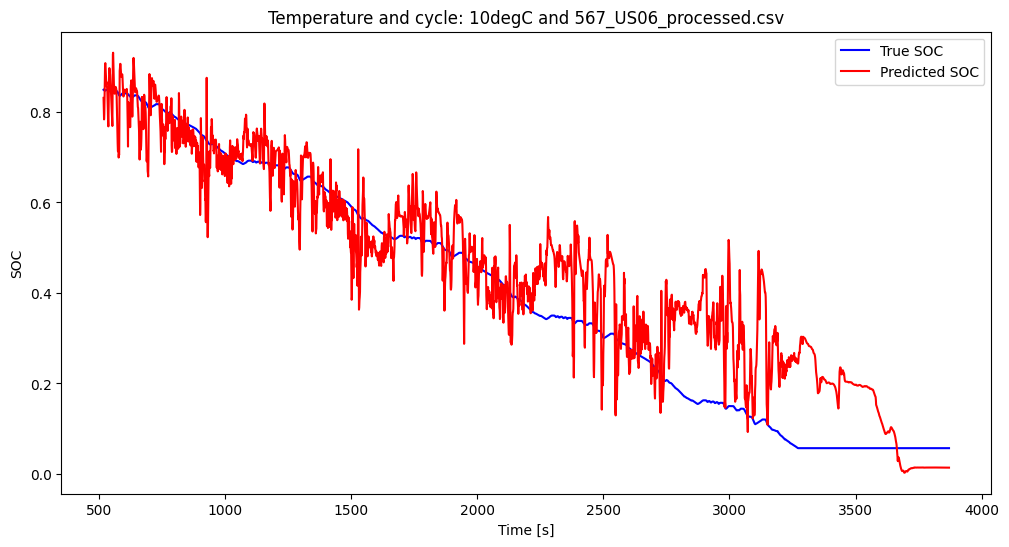


Metrics for 10degC/567_US06_processed.csv:
Test MSE: 0.011373
Test MAE: 0.081445
Test StdDev: 0.094936


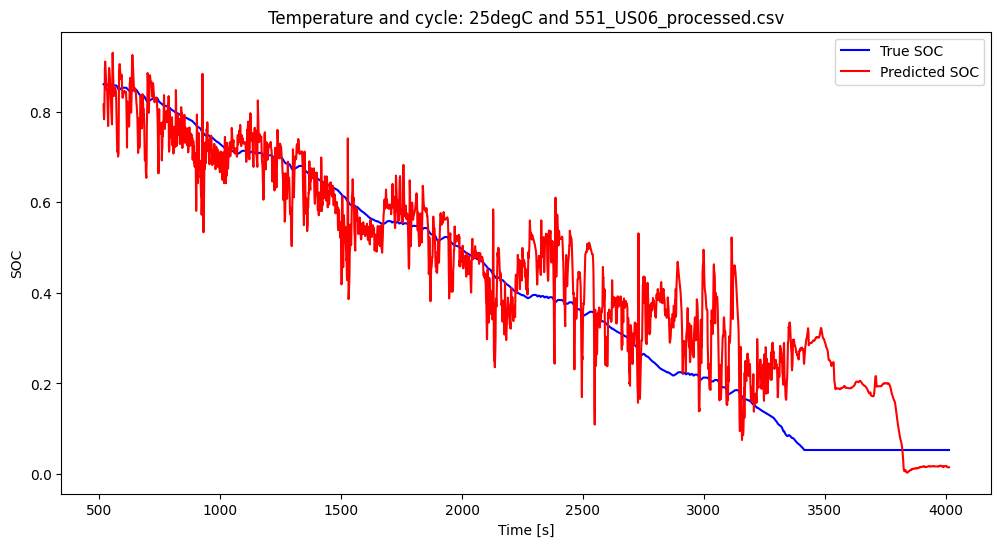


Metrics for 25degC/551_US06_processed.csv:
Test MSE: 0.009854
Test MAE: 0.076062
Test StdDev: 0.091997


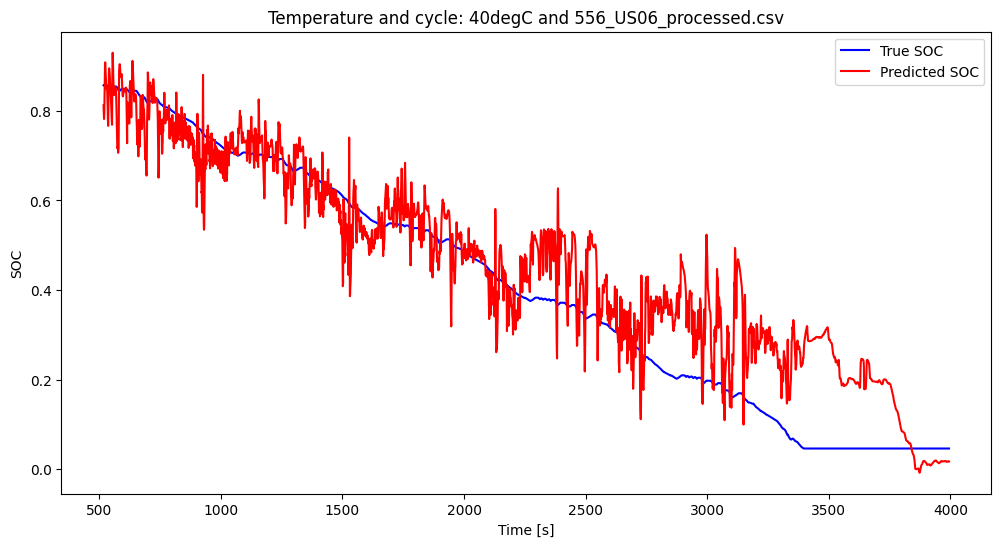


Metrics for 40degC/556_US06_processed.csv:
Test MSE: 0.011650
Test MAE: 0.081755
Test StdDev: 0.095151


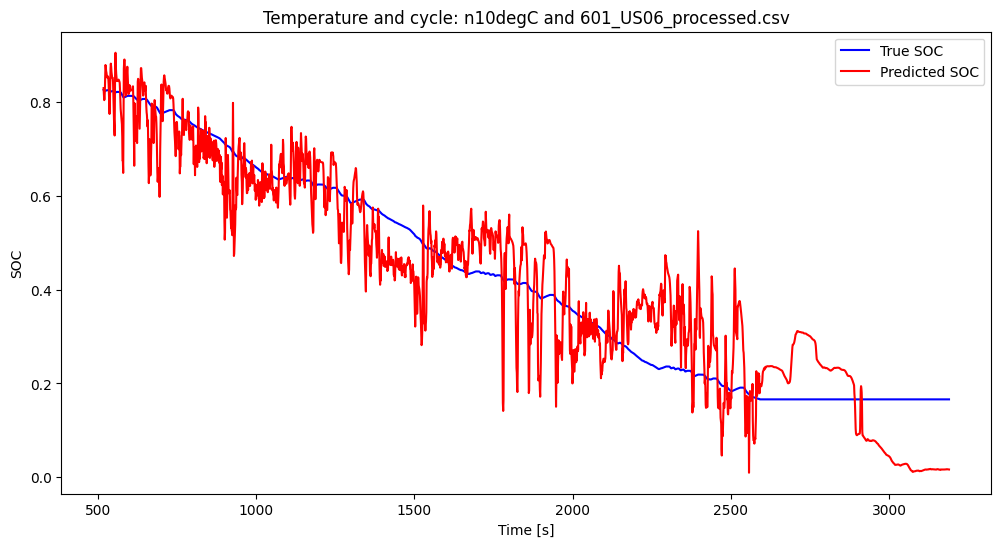


Metrics for n10degC/601_US06_processed.csv:
Test MSE: 0.008048
Test MAE: 0.074250
Test StdDev: 0.089686


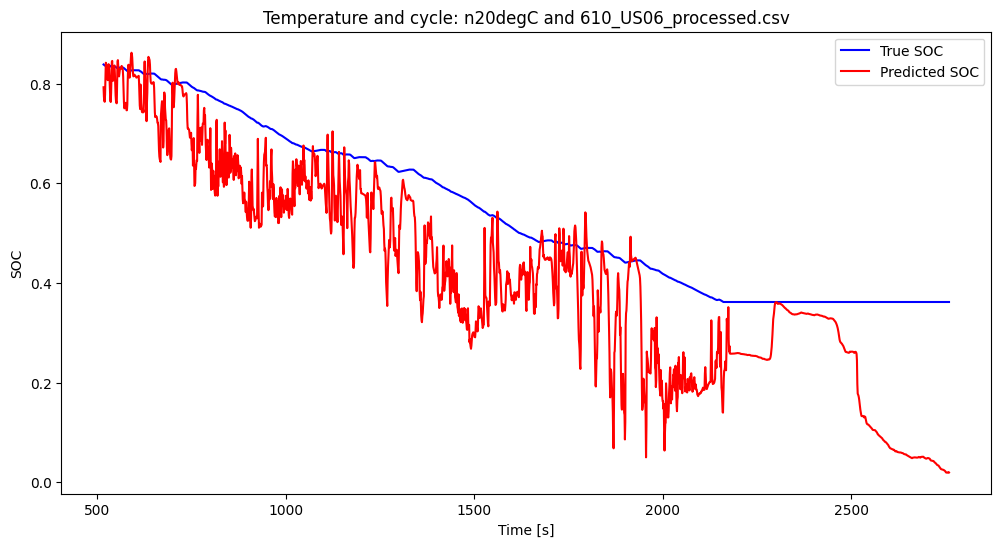


Metrics for n20degC/610_US06_processed.csv:
Test MSE: 0.024596
Test MAE: 0.127066
Test StdDev: 0.093829


In [41]:
metrics_results = evaluate_and_plot(model, collect_data('US06'))

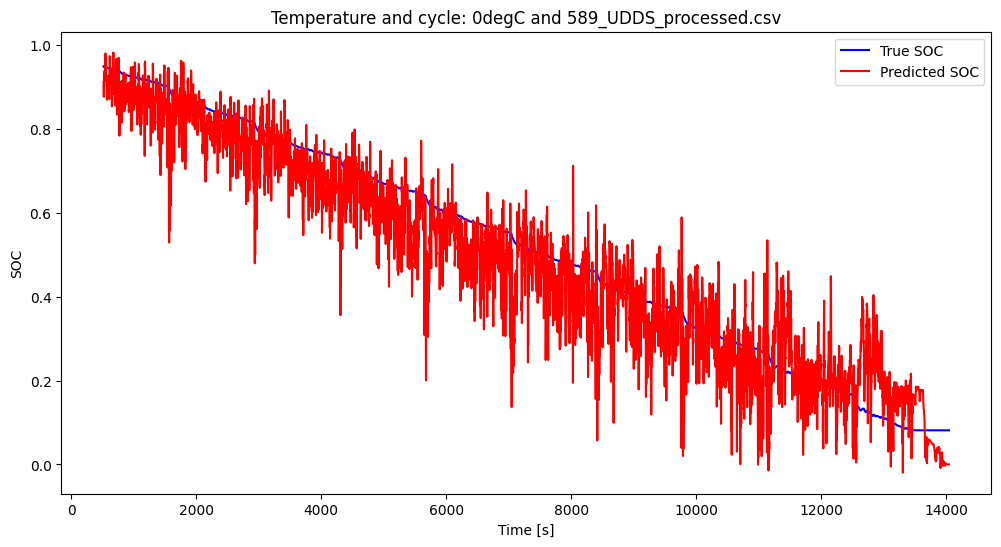


Metrics for 0degC/589_UDDS_processed.csv:
Test MSE: 0.007469
Test MAE: 0.066774
Test StdDev: 0.080581


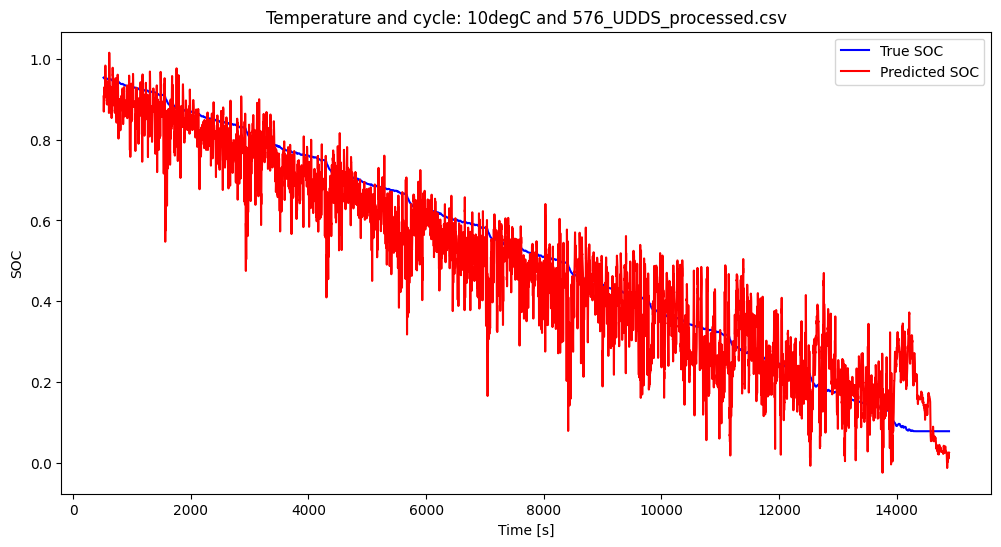


Metrics for 10degC/576_UDDS_processed.csv:
Test MSE: 0.007134
Test MAE: 0.065571
Test StdDev: 0.079601


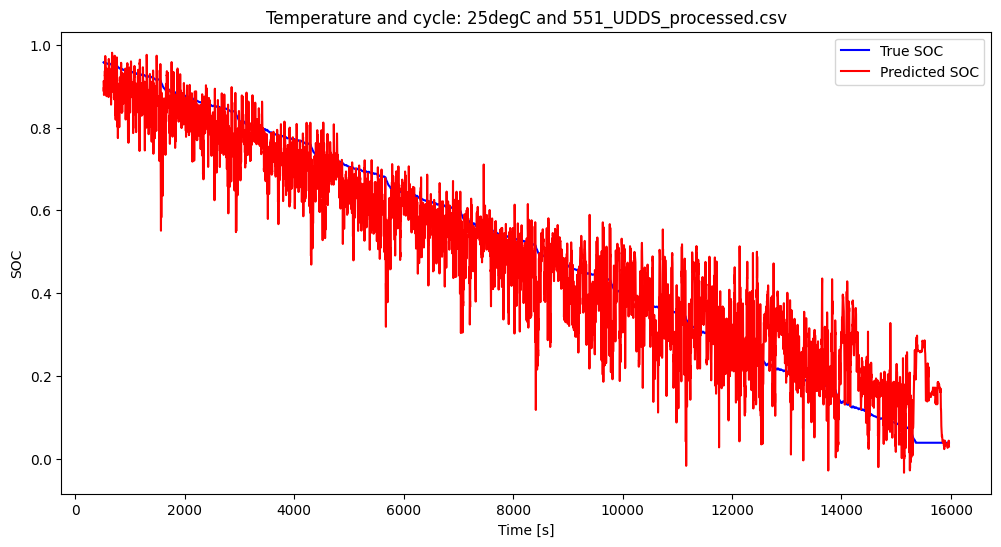


Metrics for 25degC/551_UDDS_processed.csv:
Test MSE: 0.007400
Test MAE: 0.066931
Test StdDev: 0.084710


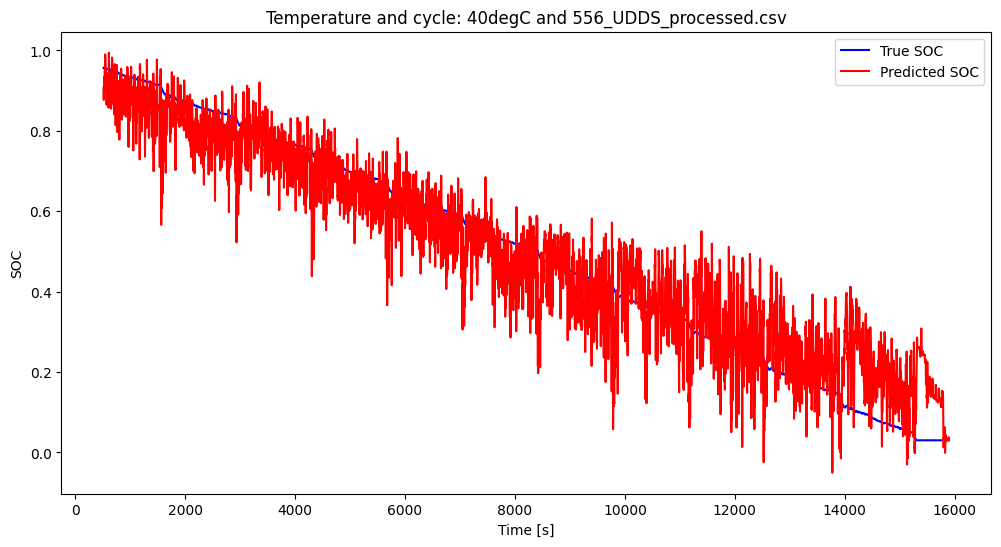


Metrics for 40degC/556_UDDS_processed.csv:
Test MSE: 0.007578
Test MAE: 0.066715
Test StdDev: 0.087048


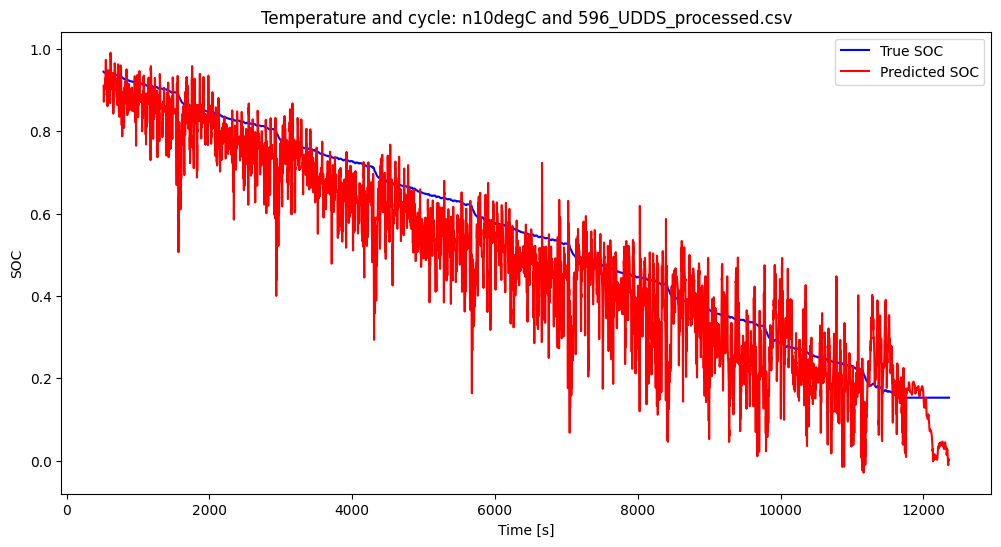


Metrics for n10degC/596_UDDS_processed.csv:
Test MSE: 0.009428
Test MAE: 0.076316
Test StdDev: 0.078440


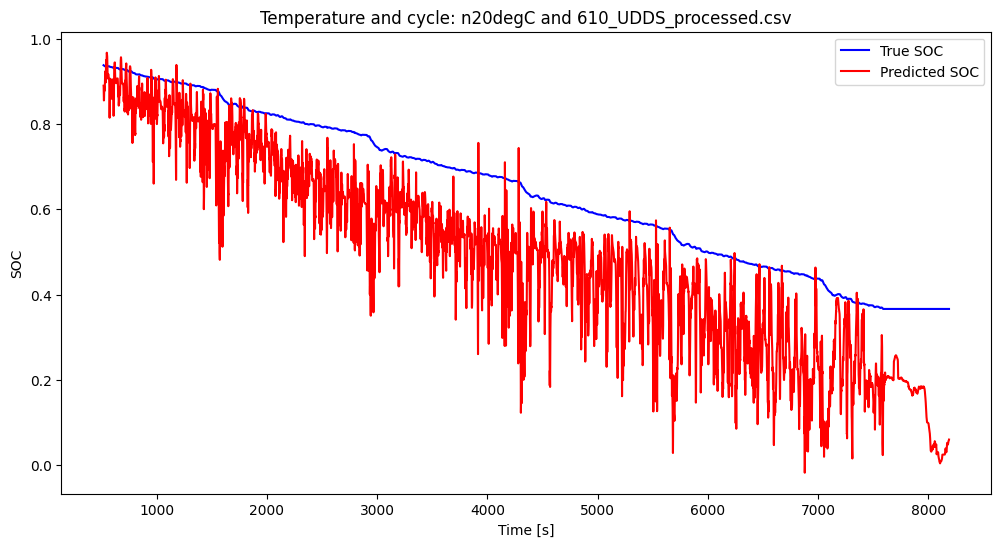


Metrics for n20degC/610_UDDS_processed.csv:
Test MSE: 0.032598
Test MAE: 0.157387
Test StdDev: 0.089126


In [42]:
metrics_results = evaluate_and_plot(model, collect_data('UDDS'))

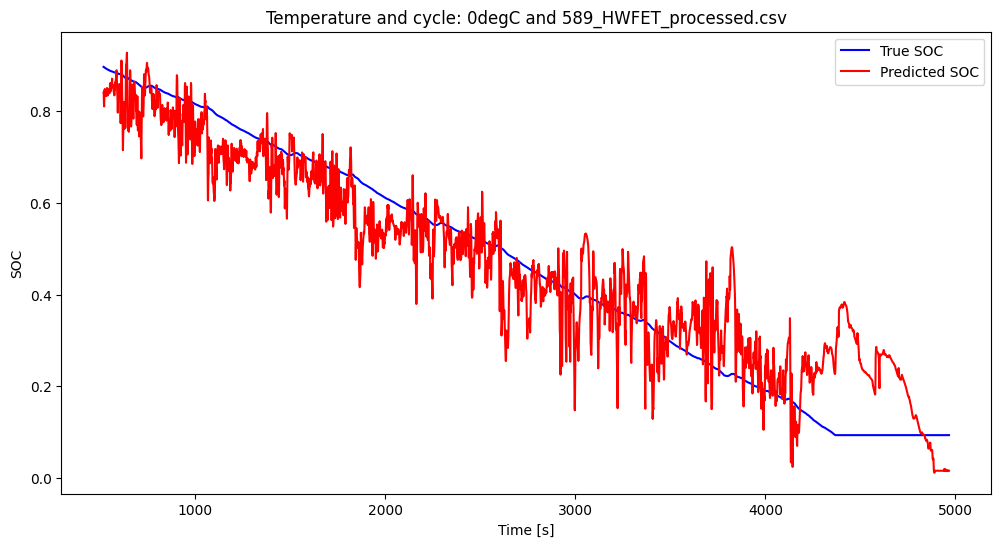


Metrics for 0degC/589_HWFET_processed.csv:
Test MSE: 0.008261
Test MAE: 0.070444
Test StdDev: 0.090851


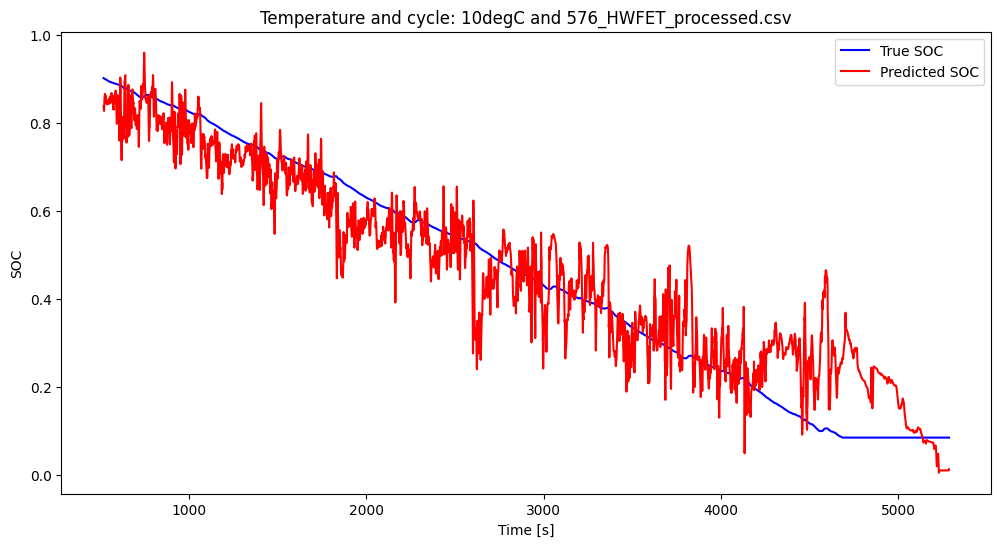


Metrics for 10degC/576_HWFET_processed.csv:
Test MSE: 0.007846
Test MAE: 0.067025
Test StdDev: 0.088352


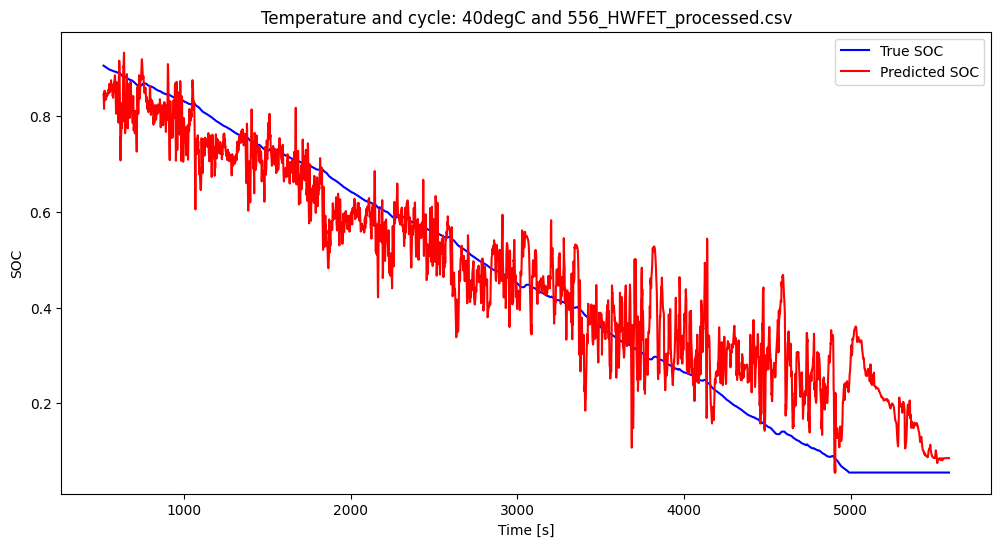


Metrics for 40degC/556_HWFET_processed.csv:
Test MSE: 0.009286
Test MAE: 0.073291
Test StdDev: 0.093322


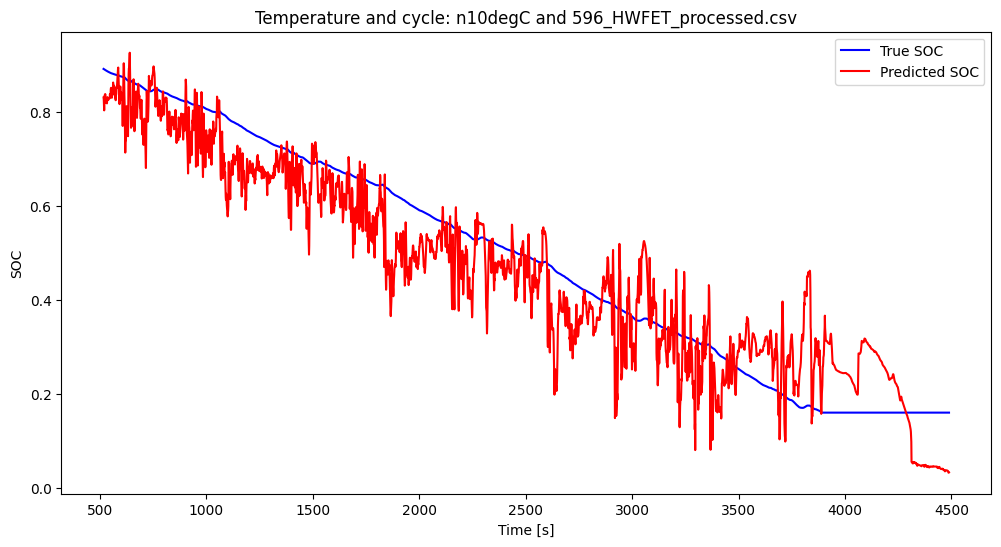


Metrics for n10degC/596_HWFET_processed.csv:
Test MSE: 0.007828
Test MAE: 0.074086
Test StdDev: 0.084307


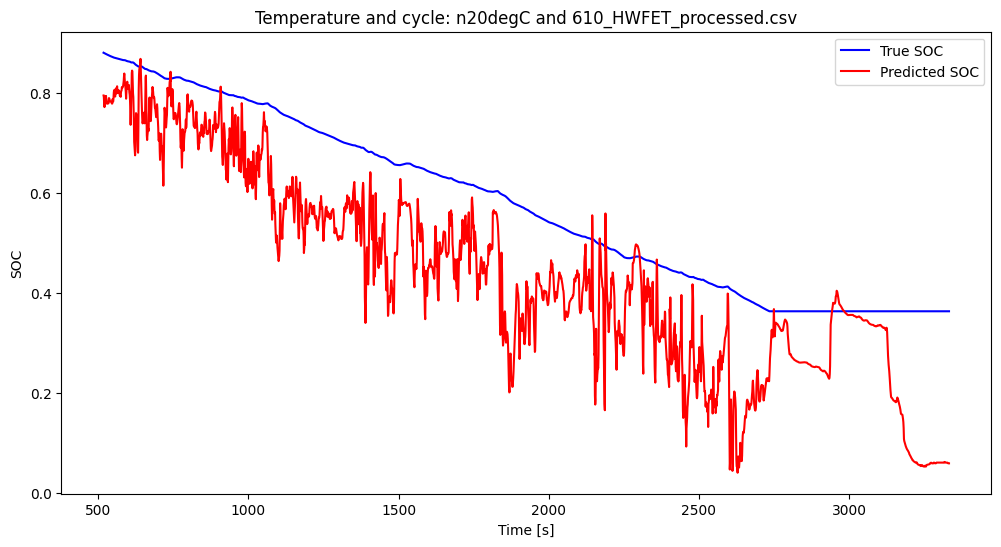


Metrics for n20degC/610_HWFET_processed.csv:
Test MSE: 0.026235
Test MAE: 0.139431
Test StdDev: 0.083814


In [43]:
metrics_results = evaluate_and_plot(model, collect_data('HWFET'))

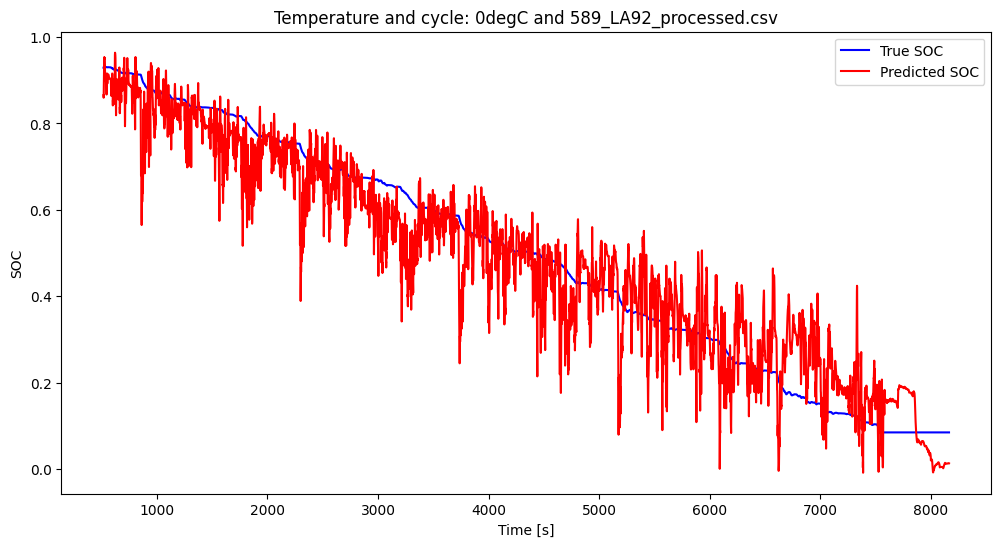


Metrics for 0degC/589_LA92_processed.csv:
Test MSE: 0.007028
Test MAE: 0.064608
Test StdDev: 0.082992


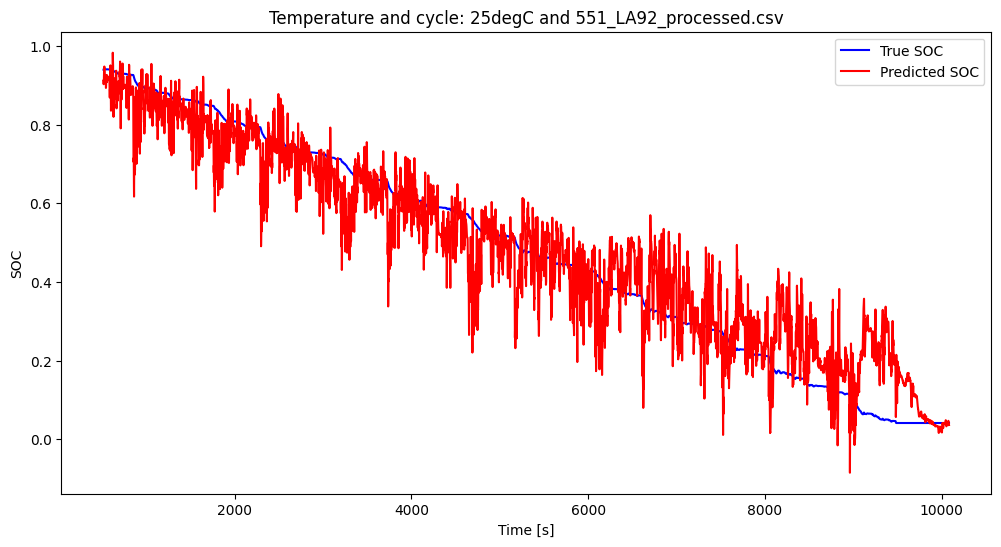


Metrics for 25degC/551_LA92_processed.csv:
Test MSE: 0.007975
Test MAE: 0.067125
Test StdDev: 0.089294


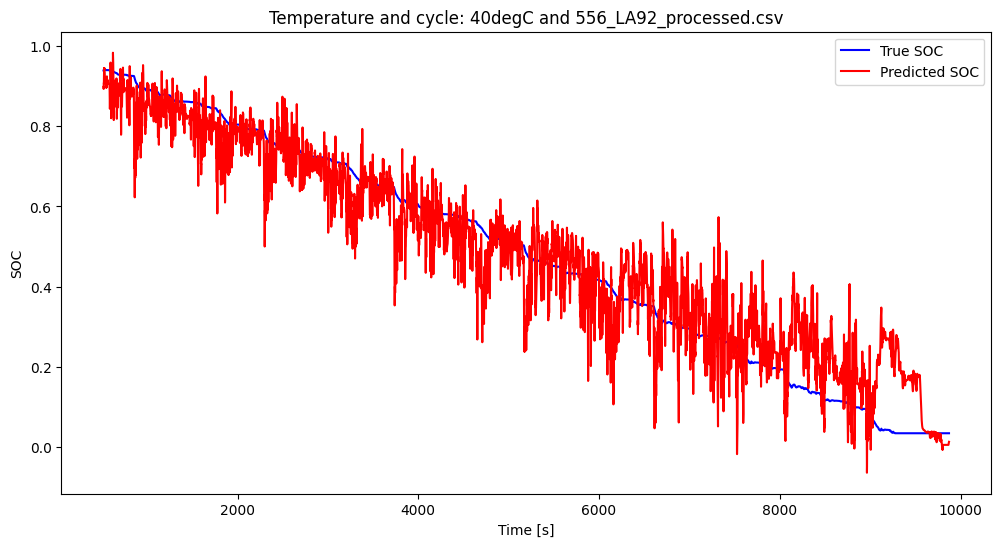


Metrics for 40degC/556_LA92_processed.csv:
Test MSE: 0.007831
Test MAE: 0.066272
Test StdDev: 0.088432


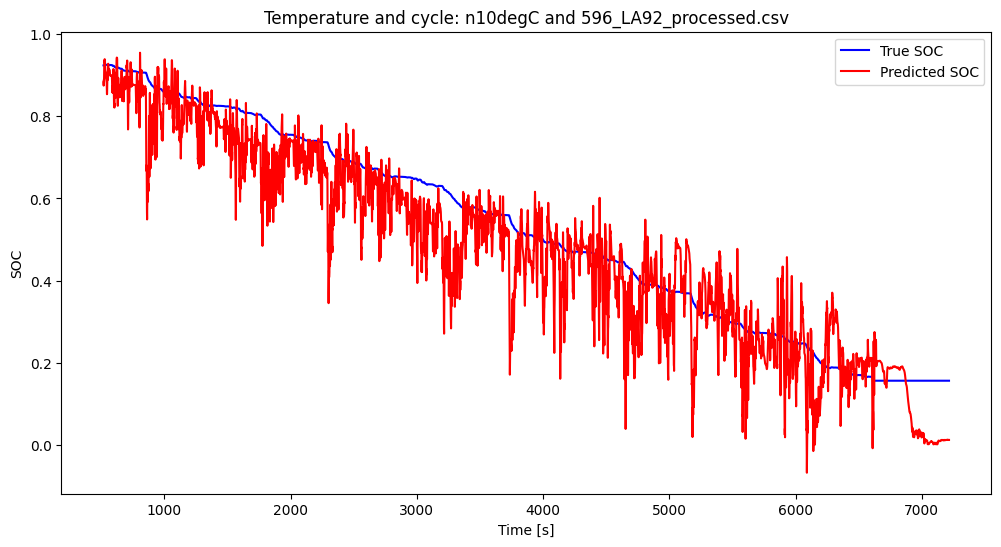


Metrics for n10degC/596_LA92_processed.csv:
Test MSE: 0.008811
Test MAE: 0.071498
Test StdDev: 0.080977


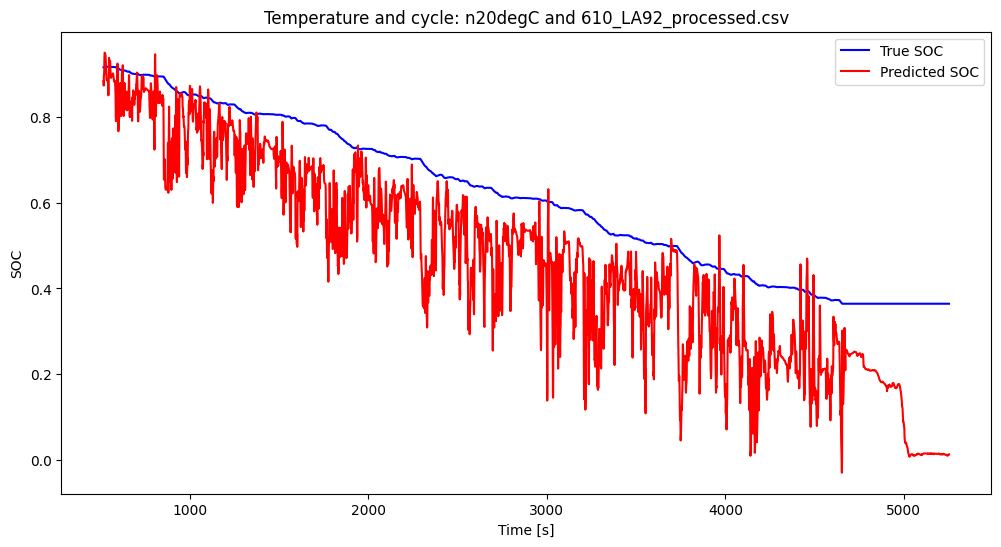


Metrics for n20degC/610_LA92_processed.csv:
Test MSE: 0.030900
Test MAE: 0.149548
Test StdDev: 0.093348


In [44]:
metrics_results = evaluate_and_plot(model, collect_data('LA92'))

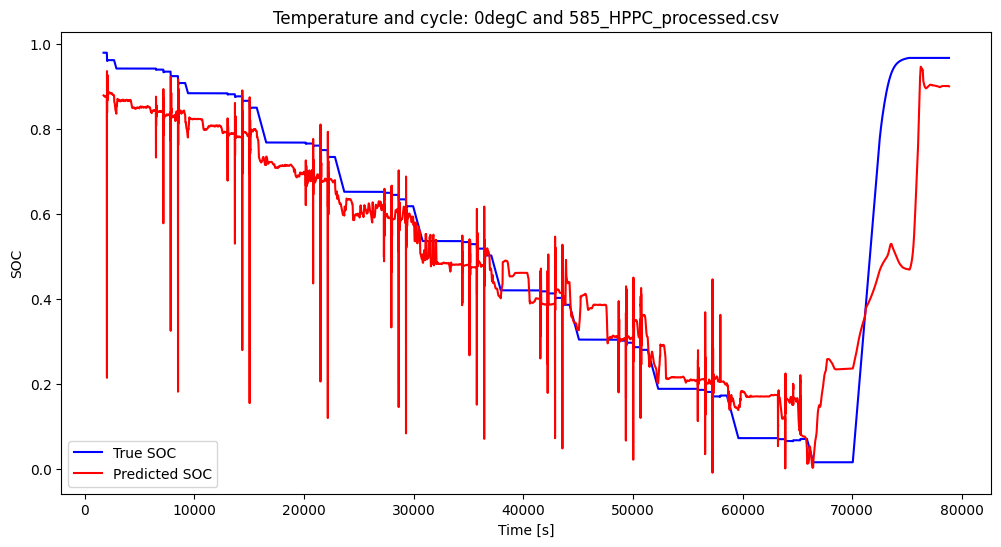


Metrics for 0degC/585_HPPC_processed.csv:
Test MSE: 0.008584
Test MAE: 0.067075
Test StdDev: 0.088803


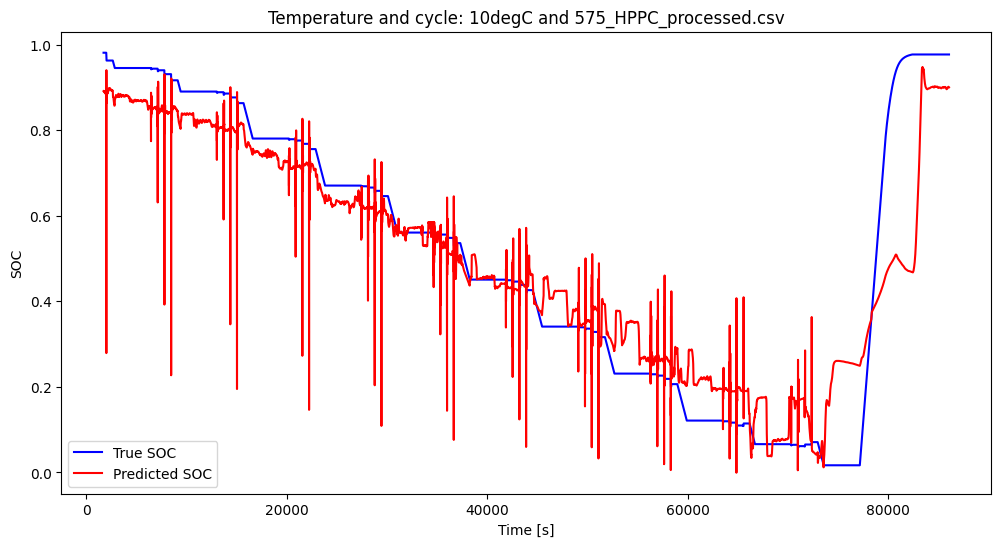


Metrics for 10degC/575_HPPC_processed.csv:
Test MSE: 0.008129
Test MAE: 0.064944
Test StdDev: 0.089782


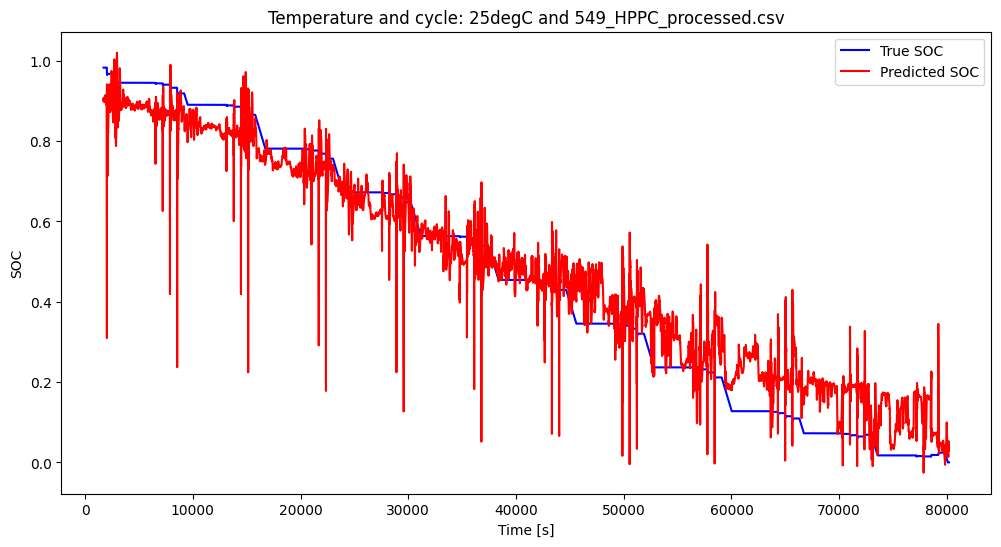


Metrics for 25degC/549_HPPC_processed.csv:
Test MSE: 0.009146
Test MAE: 0.071862
Test StdDev: 0.094658


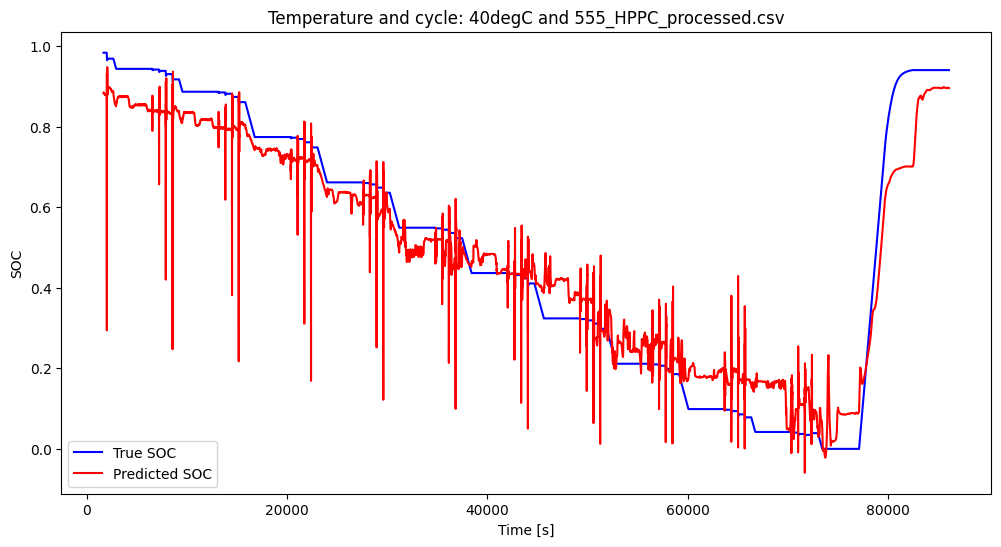


Metrics for 40degC/555_HPPC_processed.csv:
Test MSE: 0.007048
Test MAE: 0.065930
Test StdDev: 0.083722


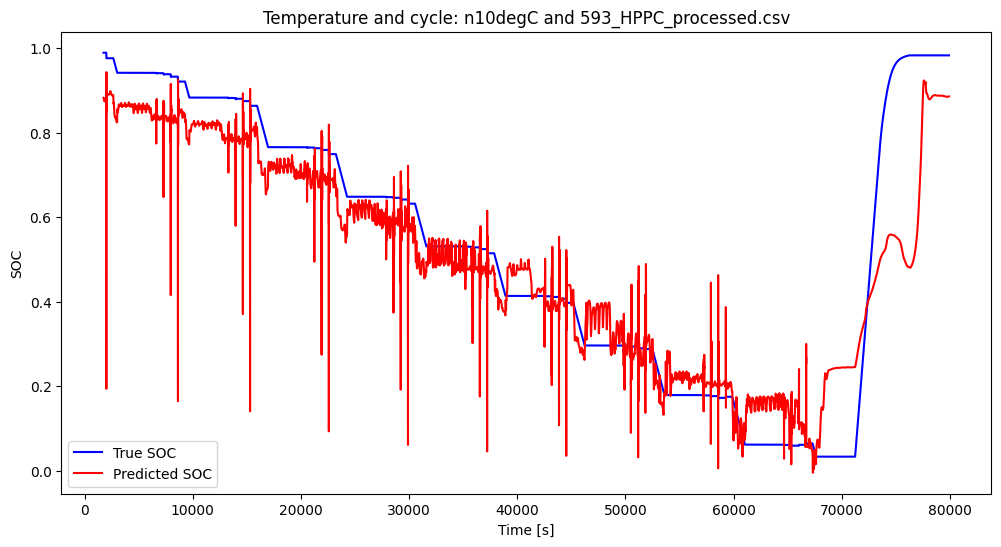


Metrics for n10degC/593_HPPC_processed.csv:
Test MSE: 0.008829
Test MAE: 0.068543
Test StdDev: 0.088651


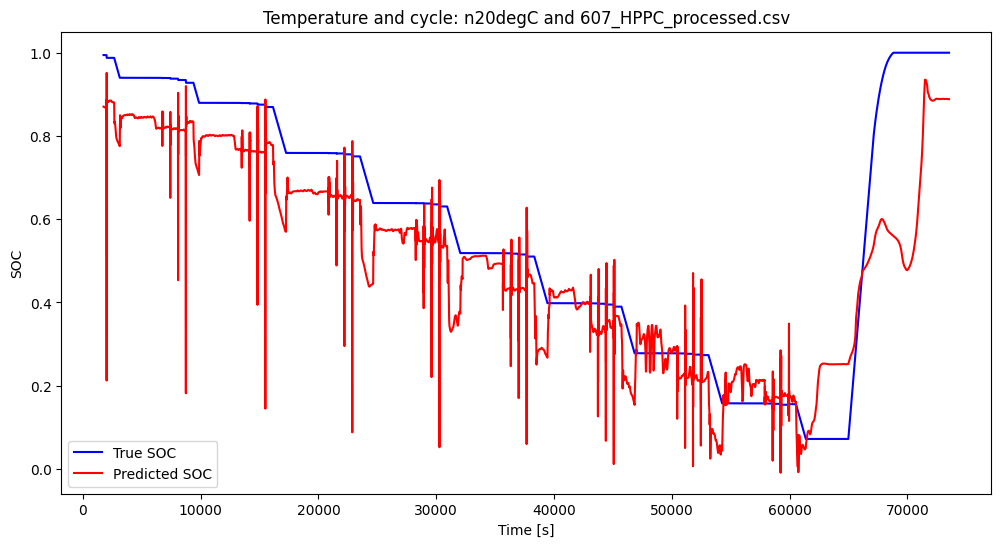


Metrics for n20degC/607_HPPC_processed.csv:
Test MSE: 0.012599
Test MAE: 0.087002
Test StdDev: 0.085498


In [45]:
metrics_results = evaluate_and_plot(model, collect_data('HPPC'))

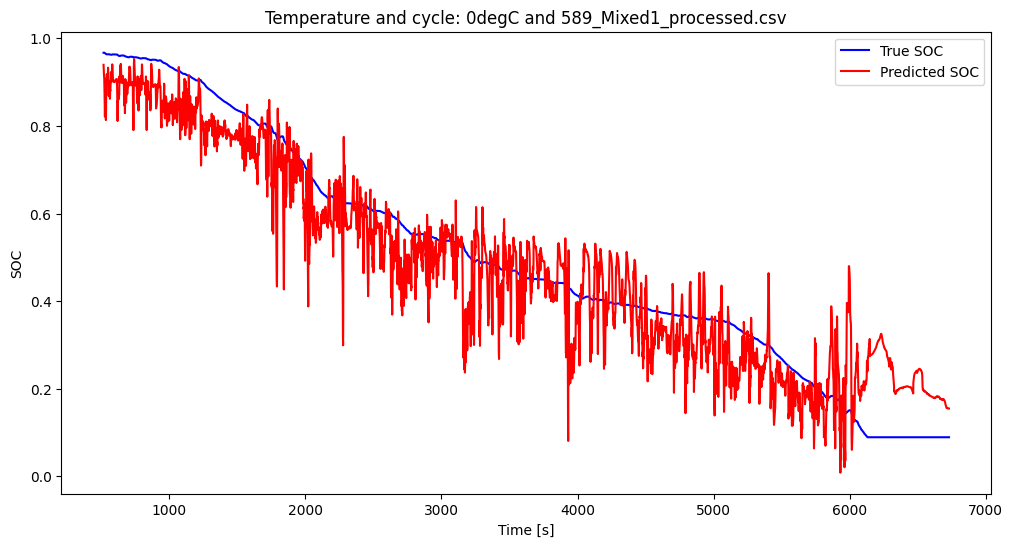


Metrics for 0degC/589_Mixed1_processed.csv:
Test MSE: 0.008139
Test MAE: 0.073535
Test StdDev: 0.087218


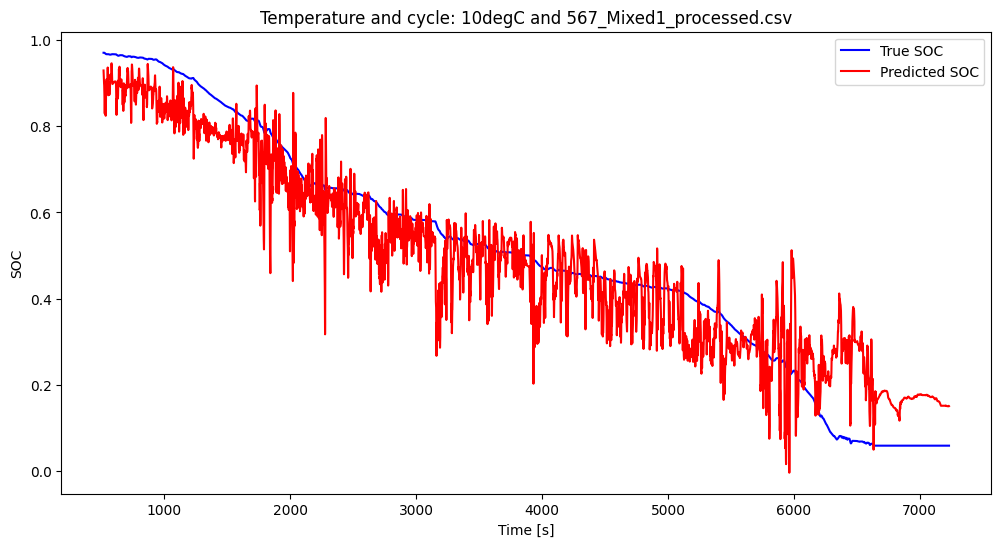


Metrics for 10degC/567_Mixed1_processed.csv:
Test MSE: 0.008890
Test MAE: 0.075925
Test StdDev: 0.092919


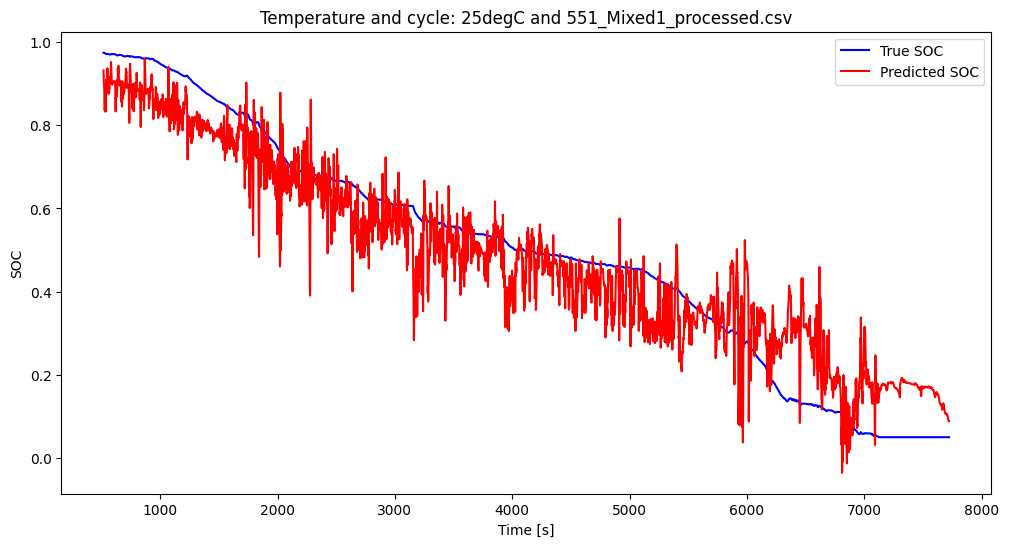


Metrics for 25degC/551_Mixed1_processed.csv:
Test MSE: 0.008872
Test MAE: 0.077866
Test StdDev: 0.092940


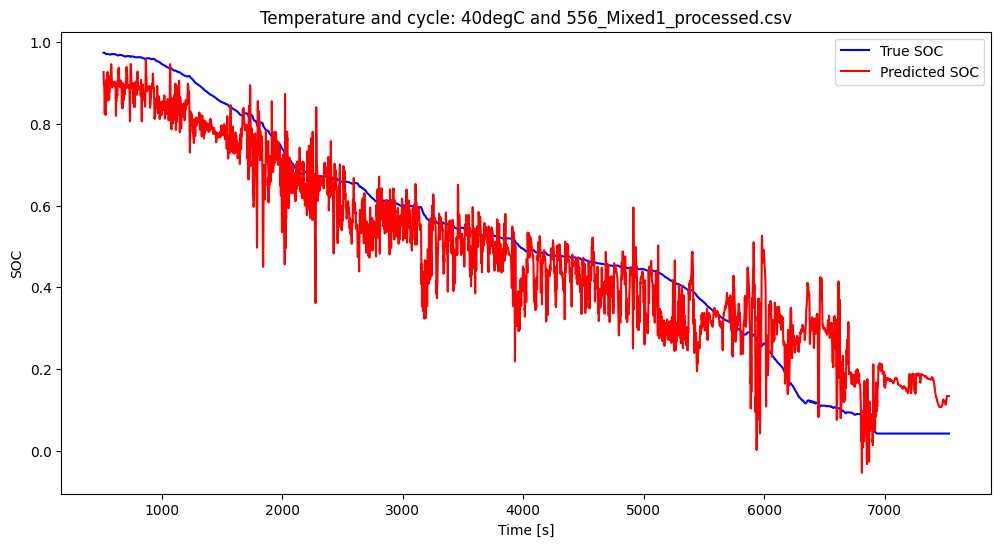


Metrics for 40degC/556_Mixed1_processed.csv:
Test MSE: 0.008948
Test MAE: 0.077182
Test StdDev: 0.093001


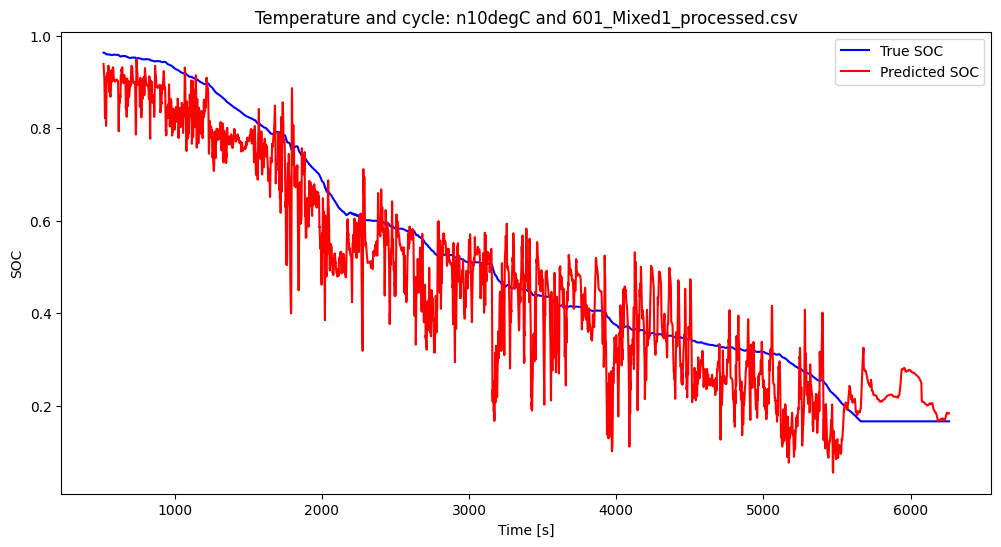


Metrics for n10degC/601_Mixed1_processed.csv:
Test MSE: 0.007816
Test MAE: 0.072395
Test StdDev: 0.078117


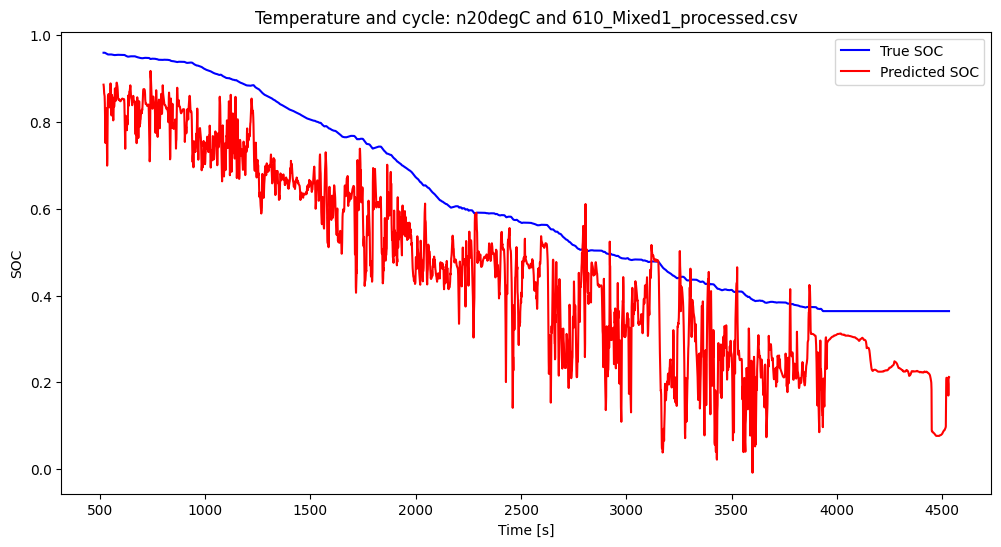


Metrics for n20degC/610_Mixed1_processed.csv:
Test MSE: 0.027084
Test MAE: 0.148651
Test StdDev: 0.071859


In [46]:
metrics_results = evaluate_and_plot(model, collect_data('Mixed1'))

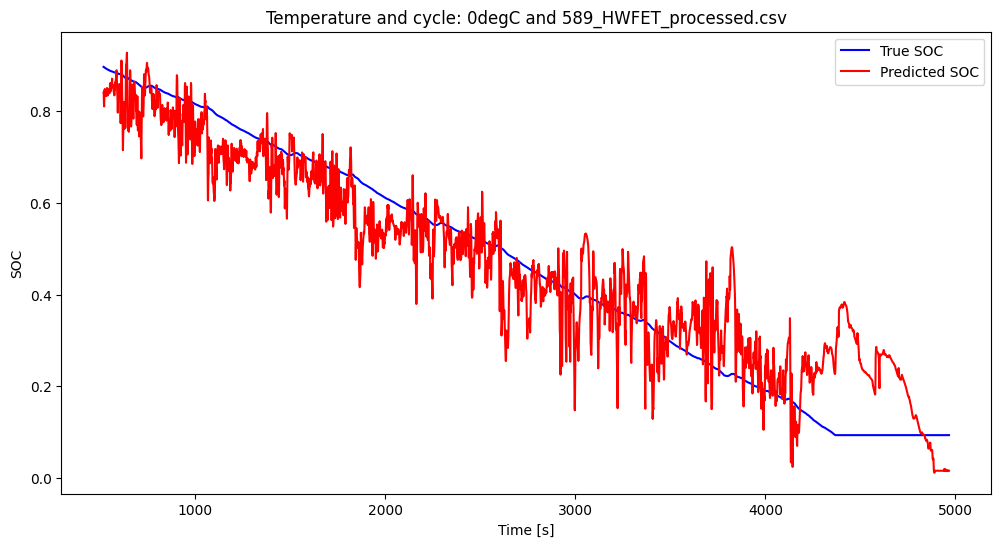


Metrics for 0degC/589_HWFET_processed.csv:
Test MSE: 0.008261
Test MAE: 0.070444
Test StdDev: 0.090851


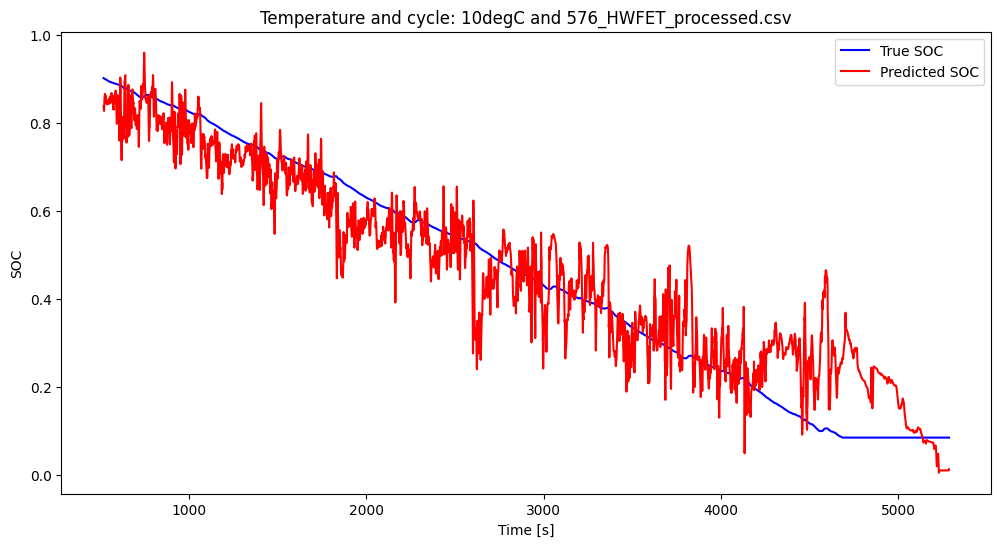


Metrics for 10degC/576_HWFET_processed.csv:
Test MSE: 0.007846
Test MAE: 0.067025
Test StdDev: 0.088352


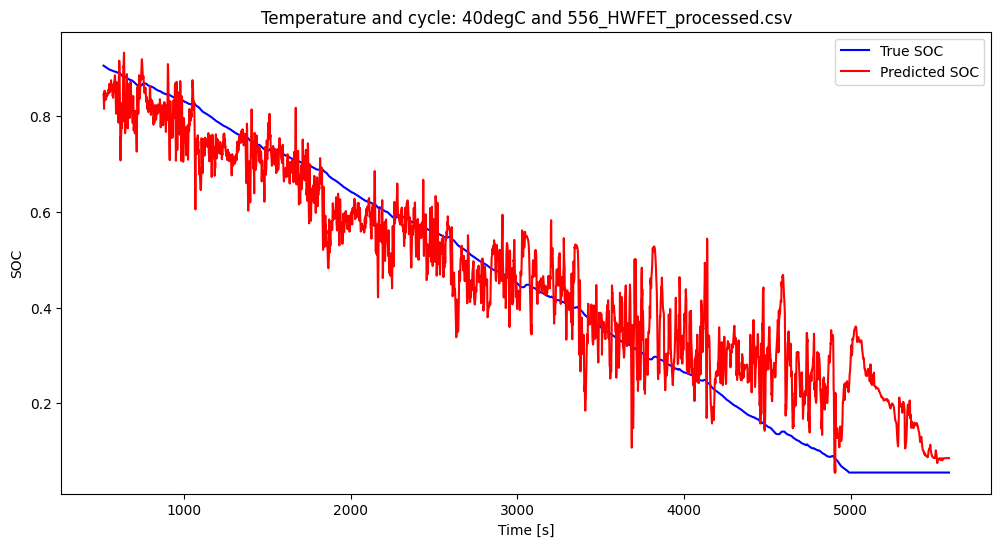


Metrics for 40degC/556_HWFET_processed.csv:
Test MSE: 0.009286
Test MAE: 0.073291
Test StdDev: 0.093322


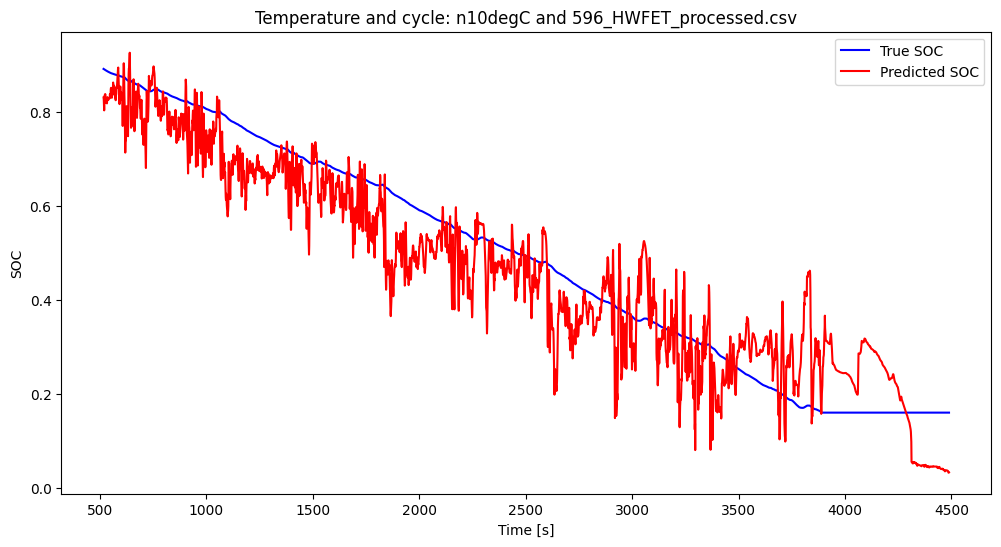


Metrics for n10degC/596_HWFET_processed.csv:
Test MSE: 0.007828
Test MAE: 0.074086
Test StdDev: 0.084307


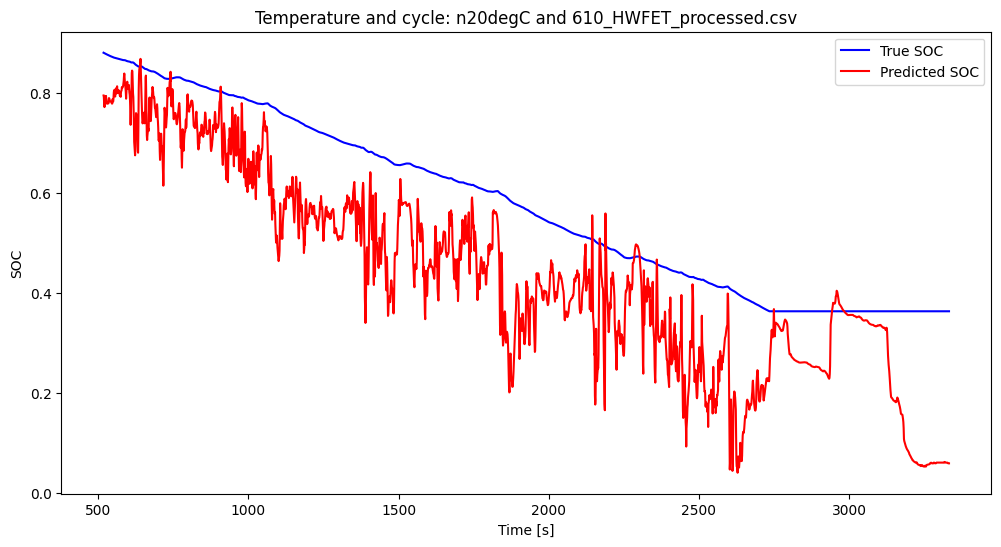


Metrics for n20degC/610_HWFET_processed.csv:
Test MSE: 0.026235
Test MAE: 0.139431
Test StdDev: 0.083814


In [65]:
metrics_results = evaluate_and_plot(model, collect_data('HWFET'))

### DNN inference, model which was build on LG dataset are testing on Panasonic dataset

In [66]:
FEATURE_COLS_LG = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'Cumulative_Capacity_Ah']
hidden_size = 105
num_layers = 3
input_size = len(FEATURE_COLS_LG)

In [67]:
model_path = "../training_and_testing/for_lg_data/soc_lstm_model.pth"
model = load_lstm_model(model_path, input_size, hidden_size, num_layers)

In [68]:
def collect_data_lstm(cycle_name):
    results = defaultdict(dict)

    base_path = '../datasets/Panasonic_dataset/Panasonic_processed'


    temp_folders = ['0degC', '10degC', '25degC', 'n10degC', 'n20degC']


    for temp_folder in temp_folders:
        folder_path = os.path.join(base_path, temp_folder)

        for file in os.listdir(folder_path):
            if cycle_name in file and file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                

                test_df = pd.read_csv(file_path)
                test_df['Power [W]'] = test_df['Voltage [V]'] * test_df['Current [A]']
                
                rolling_window = 500
                test_df['Voltage Average'] = test_df['Voltage [V]'].rolling(rolling_window).mean()
                test_df['Current Average'] = test_df['Current [A]'].rolling(rolling_window).mean()
                test_df['SourceFile'] = file
                

                scaler = StandardScaler()
                test_df[FEATURE_COLS_LG] = scaler.fit_transform(test_df[FEATURE_COLS_LG])
                

                test_tensor = torch.tensor(test_df[FEATURE_COLS_LG].values, dtype=torch.float32)
                test_labels = torch.tensor(test_df[LABEL_COL].values, dtype=torch.float32)
                

                results[temp_folder][file] = {
                    'dataframe': test_df,
                    'tensor': test_tensor,
                    'labels': test_labels,
                    'scaler': scaler
                }
    return results

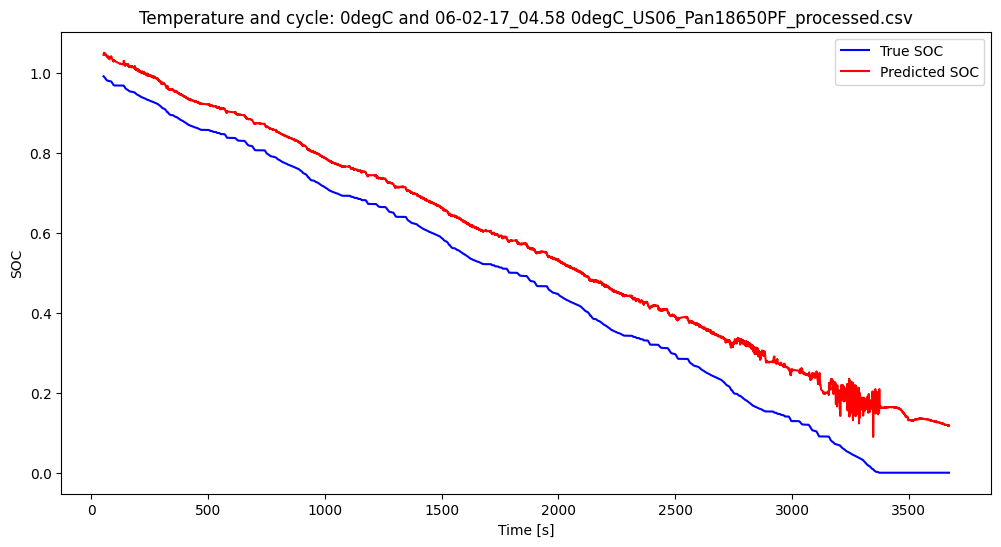


Metrics for 0degC/06-02-17_04.58 0degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.009643
Test MAE: 0.093602
Test StdDev: 0.029692


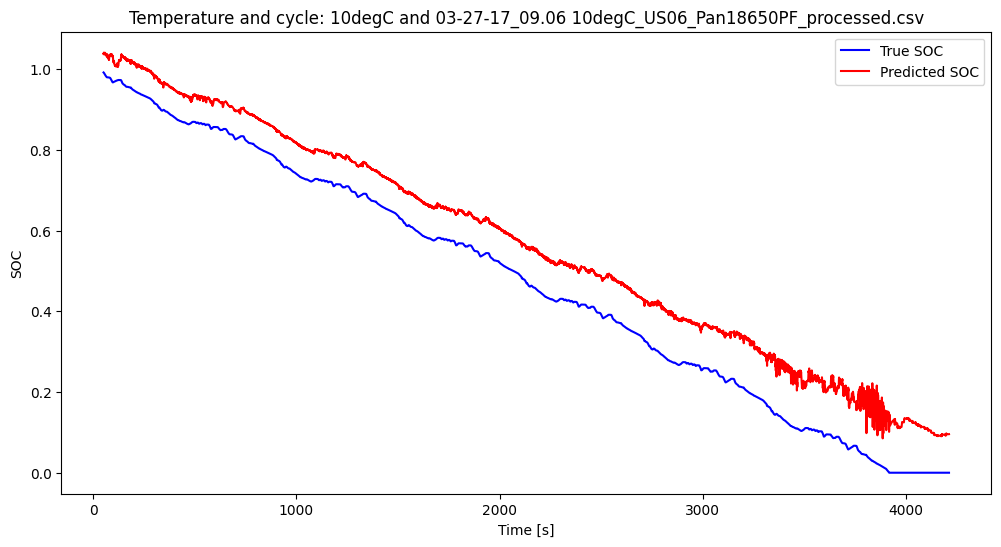


Metrics for 10degC/03-27-17_09.06 10degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.009189
Test MAE: 0.092831
Test StdDev: 0.023906


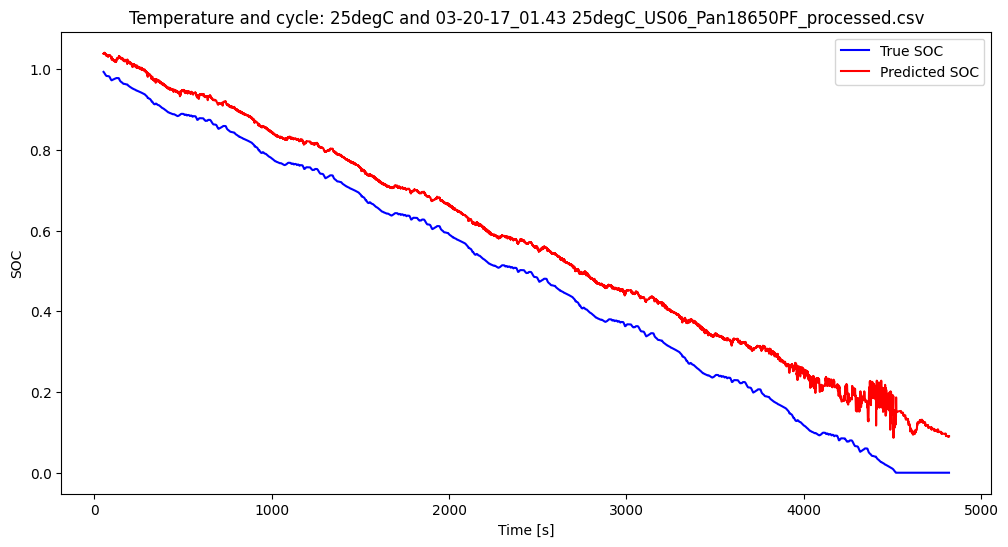


Metrics for 25degC/03-20-17_01.43 25degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.007937
Test MAE: 0.085034
Test StdDev: 0.026568


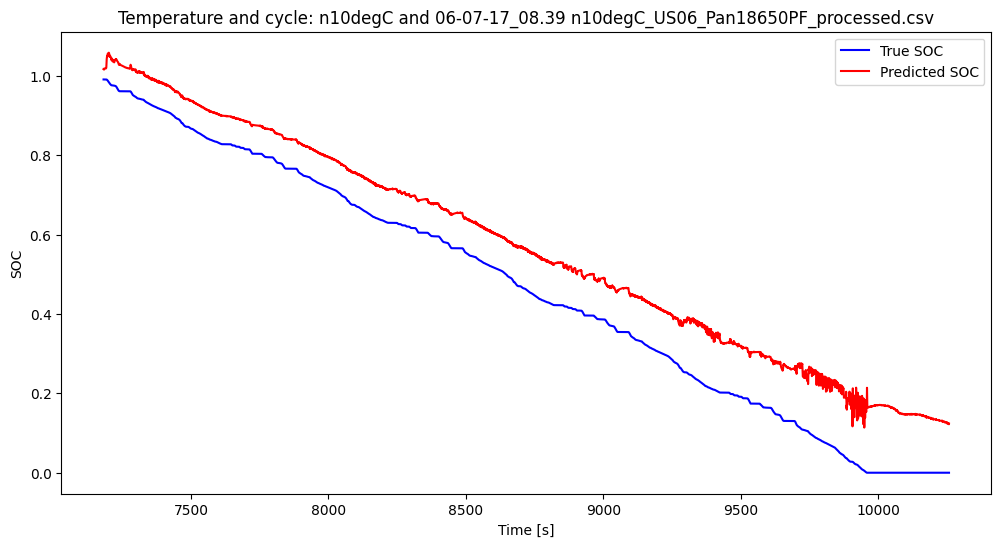


Metrics for n10degC/06-07-17_08.39 n10degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.011607
Test MAE: 0.102940
Test StdDev: 0.031779


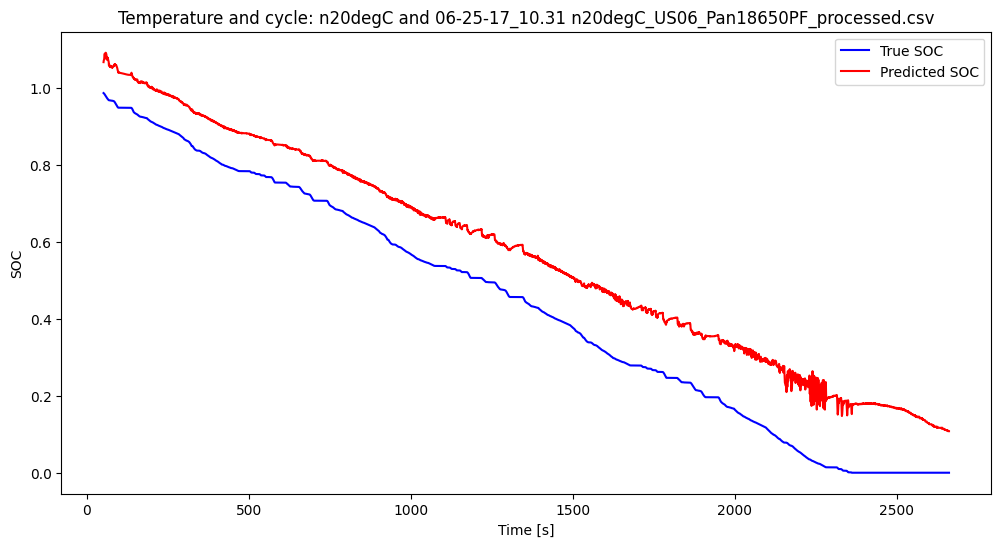


Metrics for n20degC/06-25-17_10.31 n20degC_US06_Pan18650PF_processed.csv:
Test MSE: 0.018350
Test MAE: 0.131741
Test StdDev: 0.031537


In [53]:
metrics_results = evaluate_and_plot(model, collect_data_lstm('US06'))

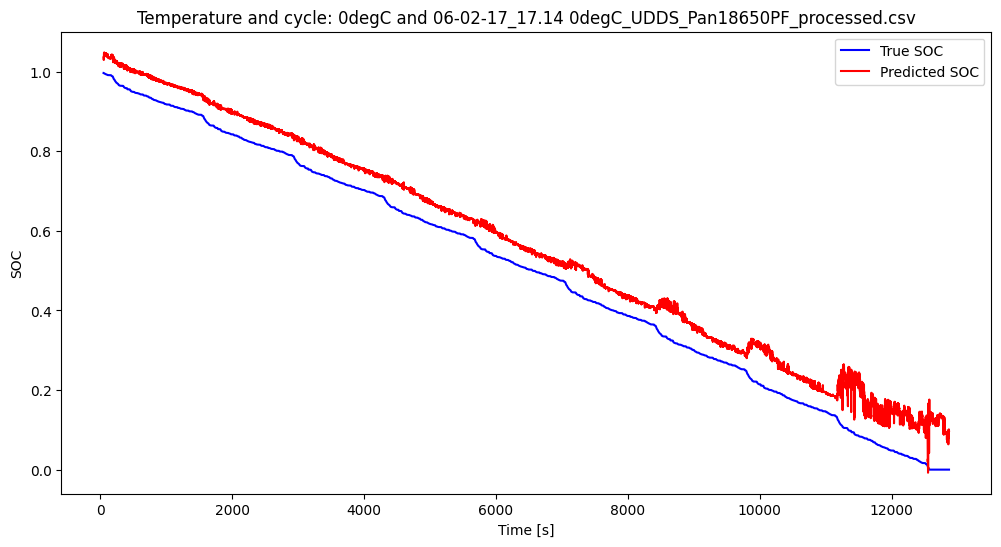


Metrics for 0degC/06-02-17_17.14 0degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.004351
Test MAE: 0.062425
Test StdDev: 0.021317


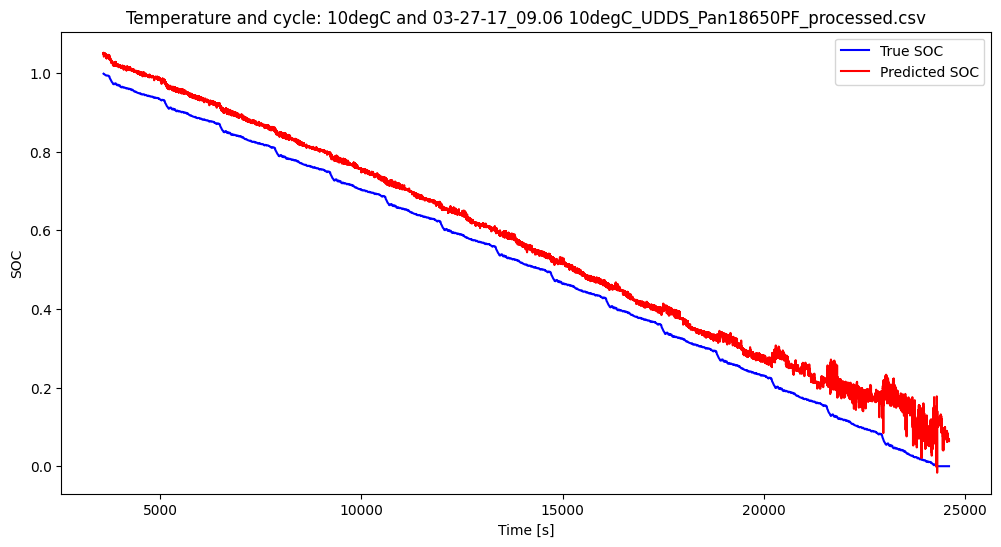


Metrics for 10degC/03-27-17_09.06 10degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.003718
Test MAE: 0.057200
Test StdDev: 0.021122


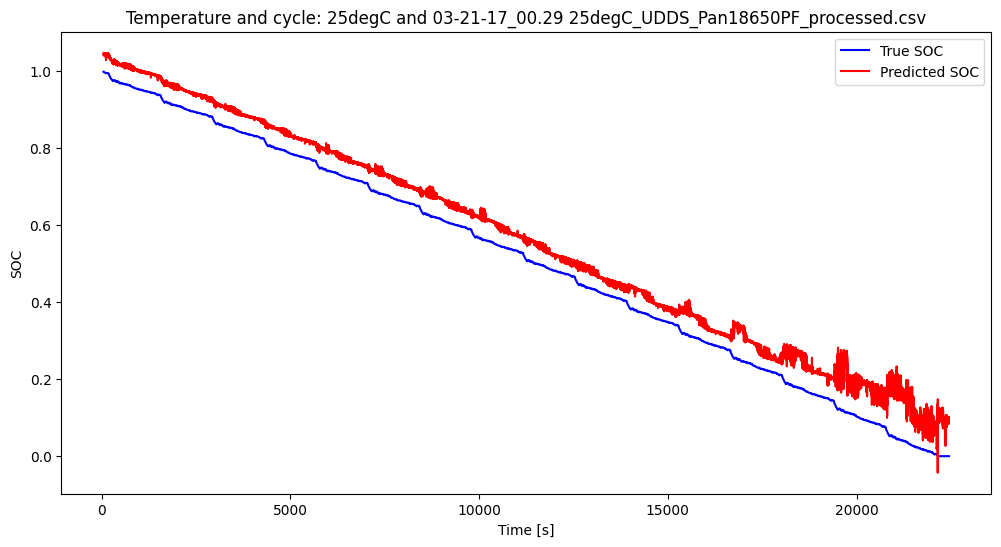


Metrics for 25degC/03-21-17_00.29 25degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.003541
Test MAE: 0.055601
Test StdDev: 0.021204


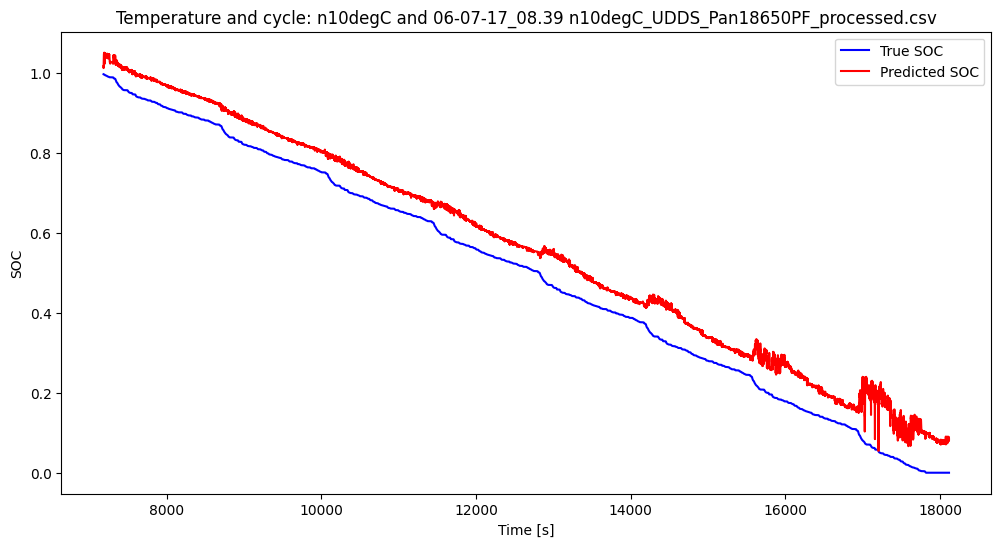


Metrics for n10degC/06-07-17_08.39 n10degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.004673
Test MAE: 0.065417
Test StdDev: 0.019830


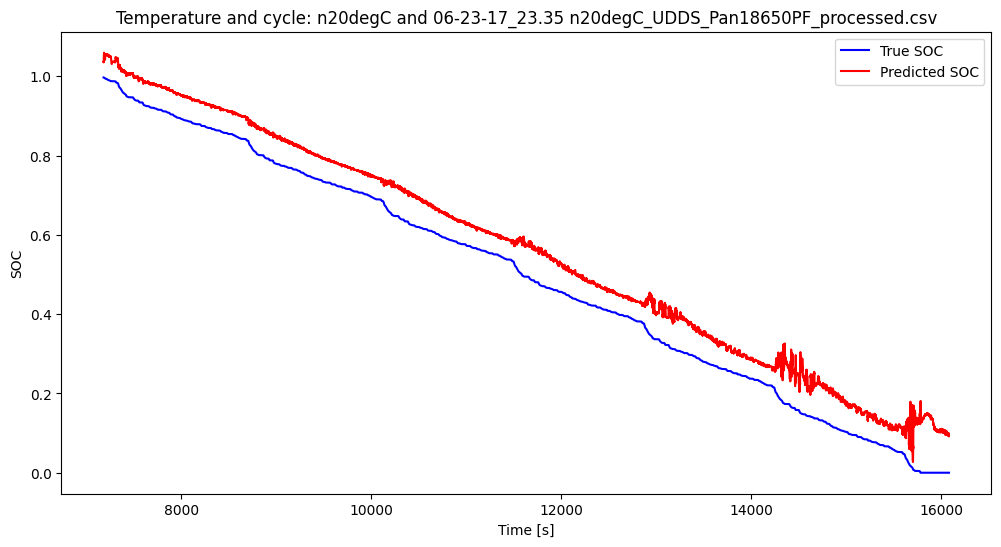


Metrics for n20degC/06-23-17_23.35 n20degC_UDDS_Pan18650PF_processed.csv:
Test MSE: 0.004840
Test MAE: 0.067043
Test StdDev: 0.018593


In [54]:
metrics_results = evaluate_and_plot(model, collect_data_lstm('UDDS'))

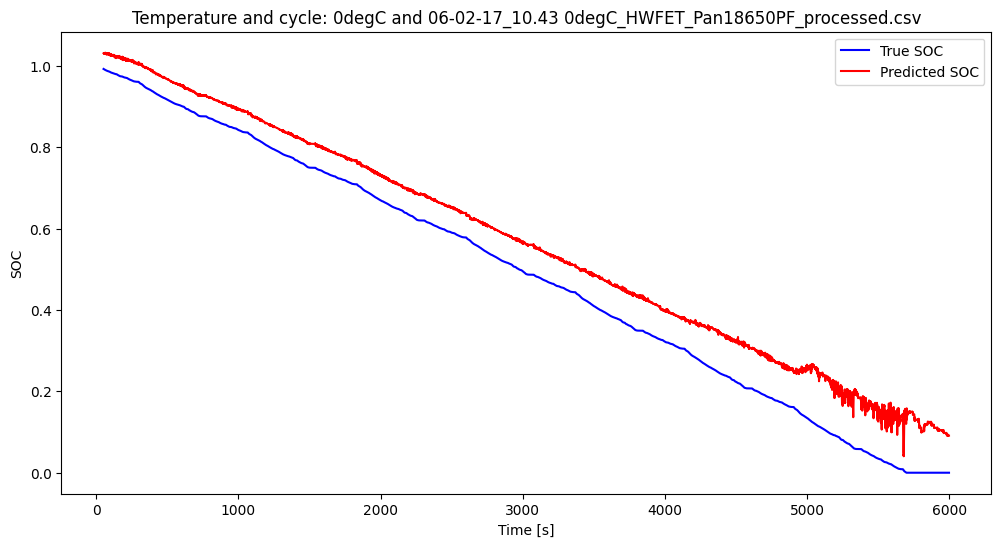


Metrics for 0degC/06-02-17_10.43 0degC_HWFET_Pan18650PF_processed.csv:
Test MSE: 0.006514
Test MAE: 0.076476
Test StdDev: 0.025794


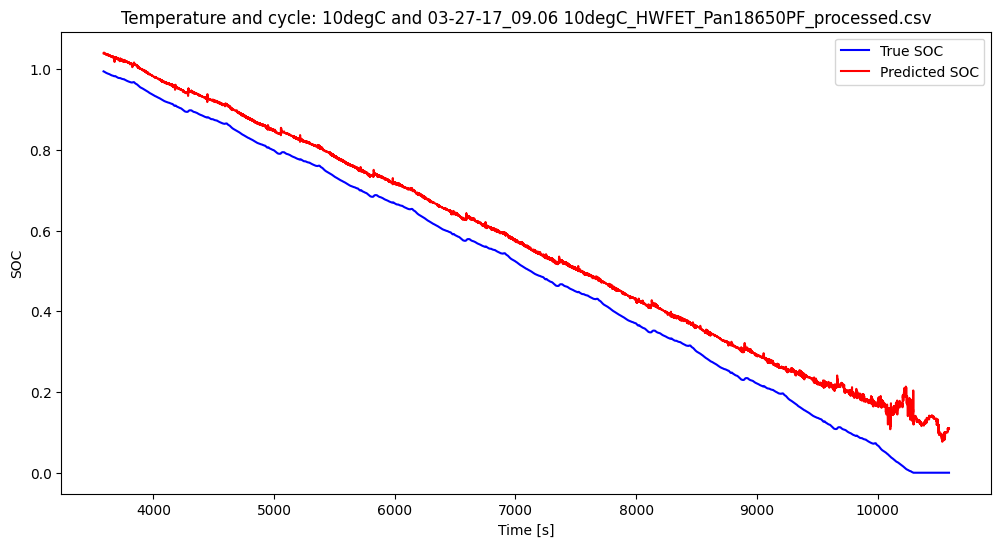


Metrics for 10degC/03-27-17_09.06 10degC_HWFET_Pan18650PF_processed.csv:
Test MSE: 0.004790
Test MAE: 0.064571
Test StdDev: 0.024914


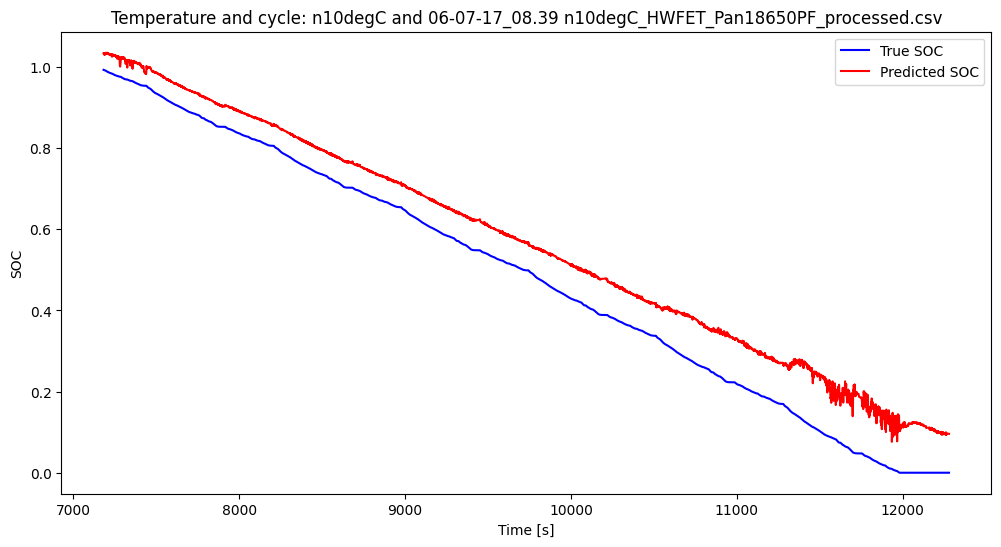


Metrics for n10degC/06-07-17_08.39 n10degC_HWFET_Pan18650PF_processed.csv:
Test MSE: 0.007365
Test MAE: 0.081414
Test StdDev: 0.027150


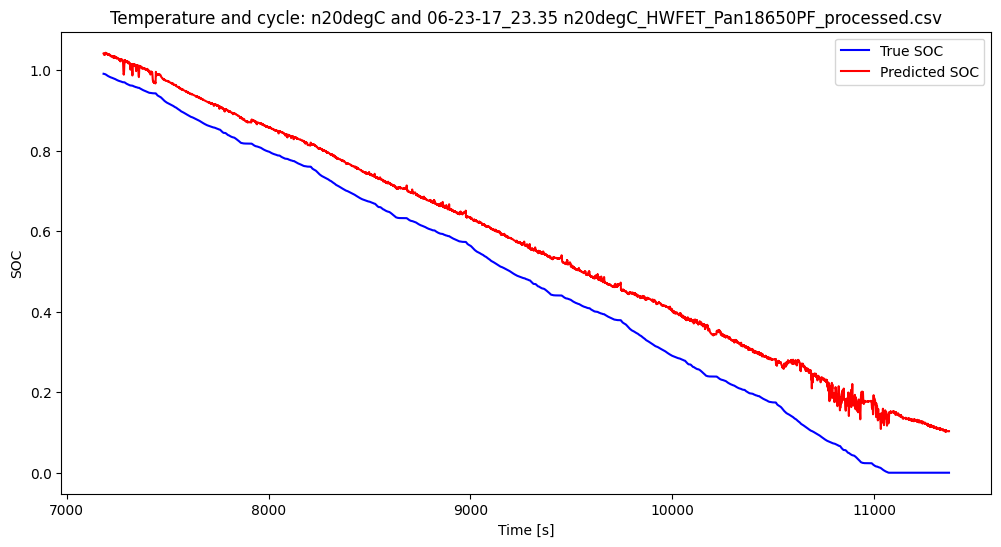


Metrics for n20degC/06-23-17_23.35 n20degC_HWFET_Pan18650PF_processed.csv:
Test MSE: 0.008702
Test MAE: 0.088528
Test StdDev: 0.029411


In [55]:
metrics_results = evaluate_and_plot(model, collect_data_lstm('HWFET'))

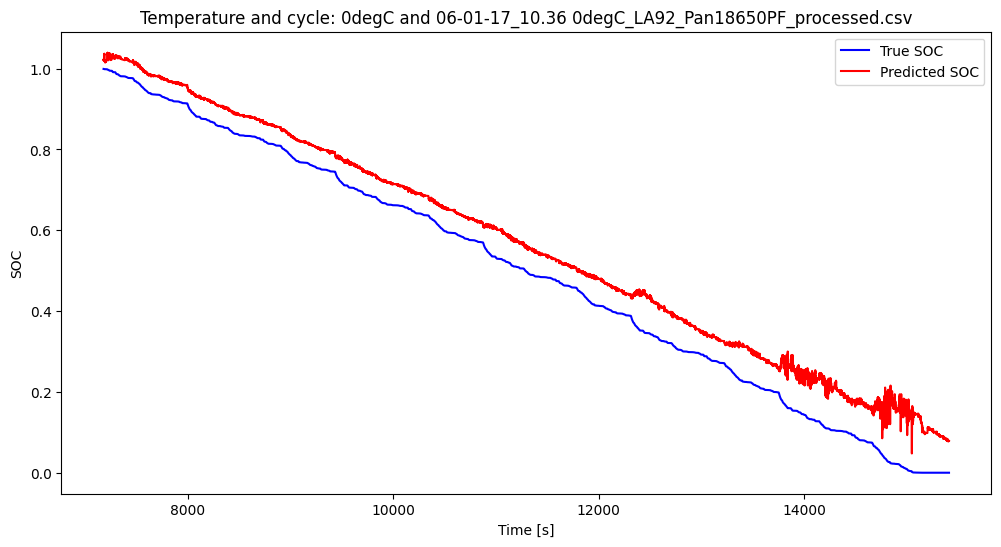


Metrics for 0degC/06-01-17_10.36 0degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.005060
Test MAE: 0.066591
Test StdDev: 0.025005


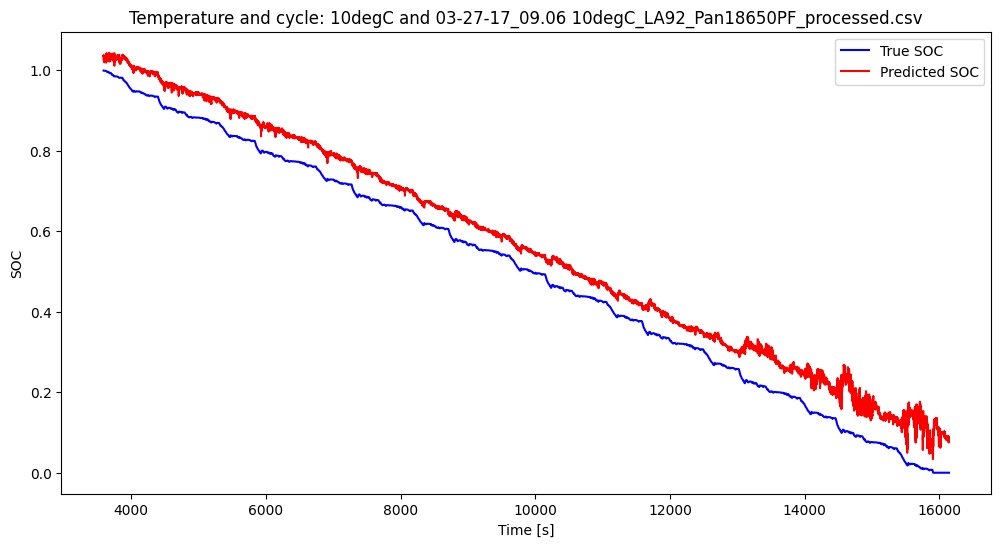


Metrics for 10degC/03-27-17_09.06 10degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.004365
Test MAE: 0.063209
Test StdDev: 0.019216


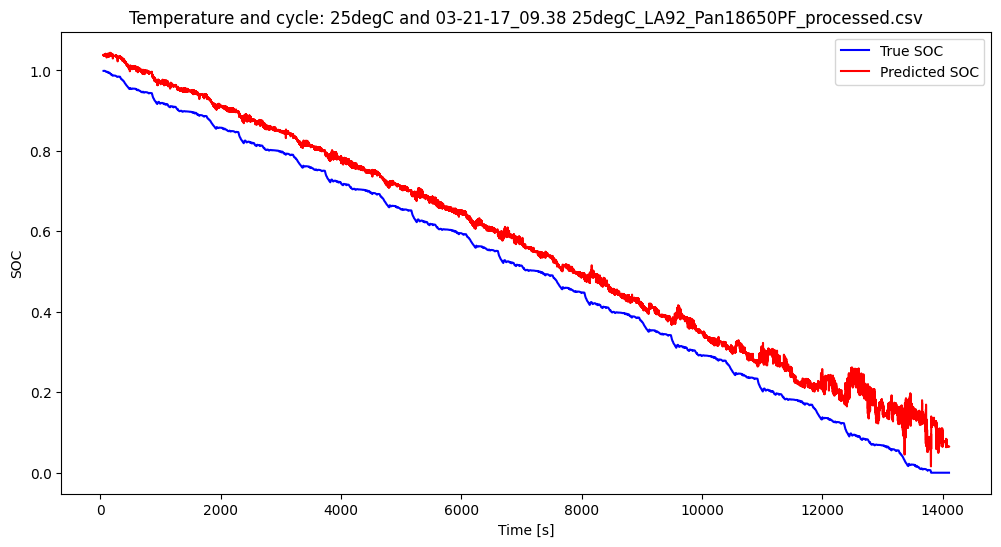


Metrics for 25degC/03-21-17_09.38 25degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.004357
Test MAE: 0.062077
Test StdDev: 0.022427


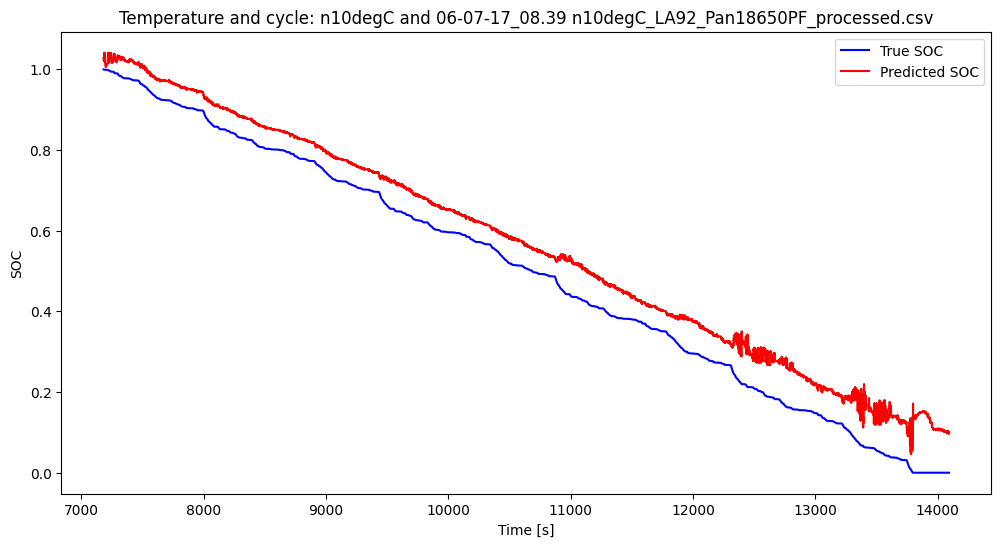


Metrics for n10degC/06-07-17_08.39 n10degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.004932
Test MAE: 0.066436
Test StdDev: 0.022758


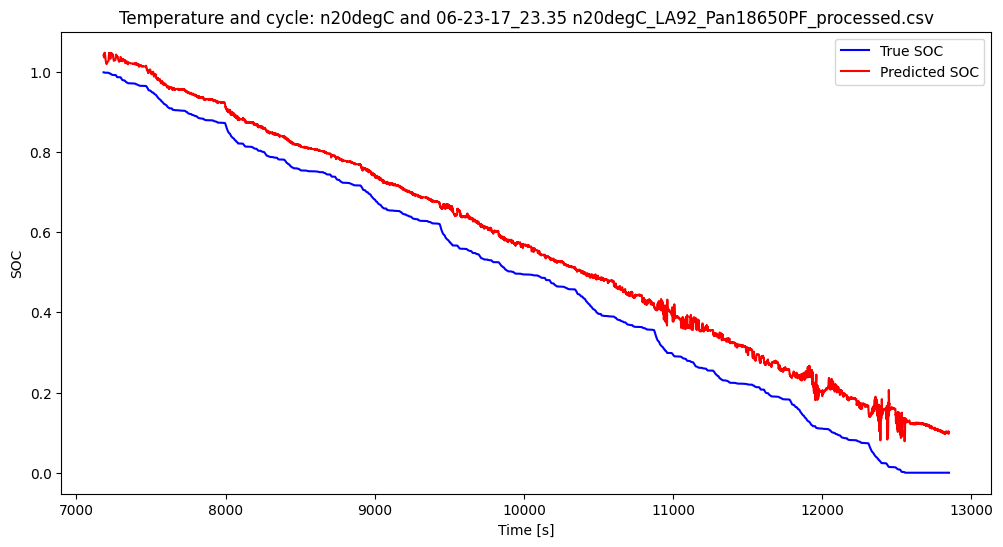


Metrics for n20degC/06-23-17_23.35 n20degC_LA92_Pan18650PF_processed.csv:
Test MSE: 0.006285
Test MAE: 0.075652
Test StdDev: 0.023695


In [69]:
metrics_results = evaluate_and_plot(model, collect_data_lstm('LA92'))

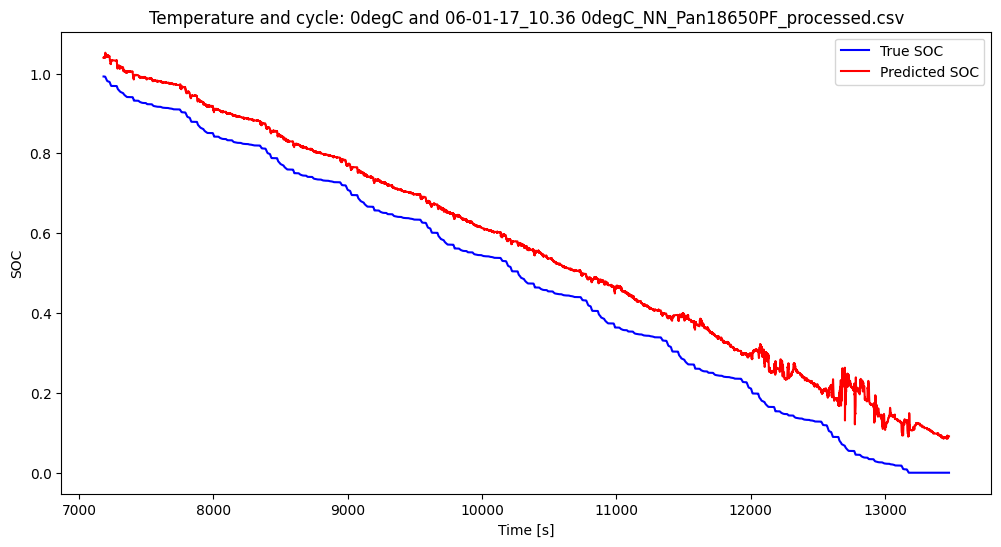


Metrics for 0degC/06-01-17_10.36 0degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.007480
Test MAE: 0.083090
Test StdDev: 0.024008


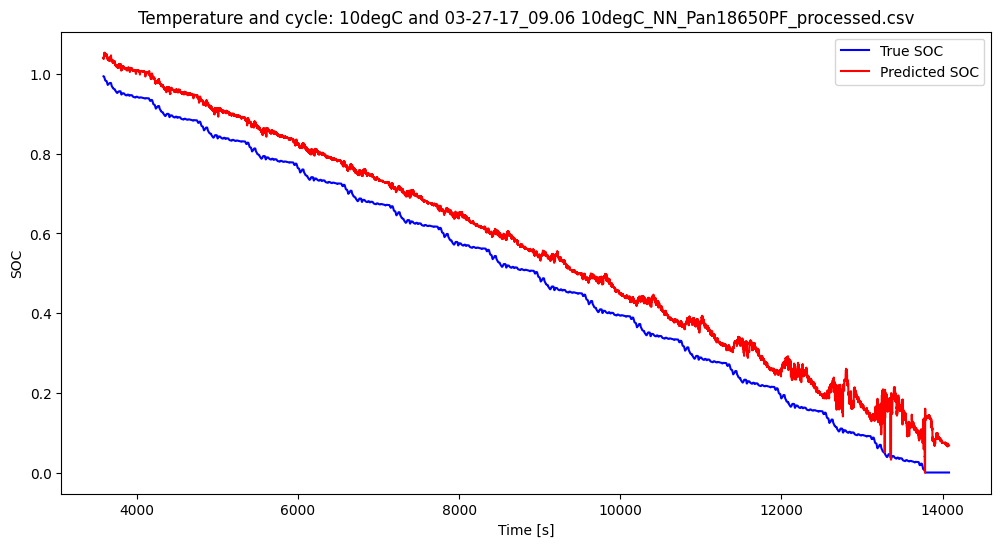


Metrics for 10degC/03-27-17_09.06 10degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.005197
Test MAE: 0.069609
Test StdDev: 0.018764


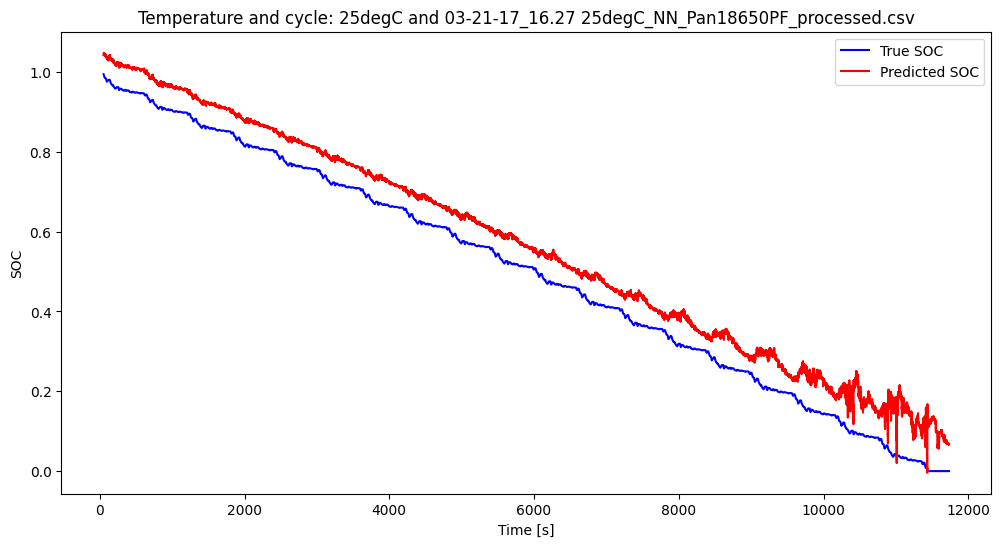


Metrics for 25degC/03-21-17_16.27 25degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.004616
Test MAE: 0.065141
Test StdDev: 0.019318


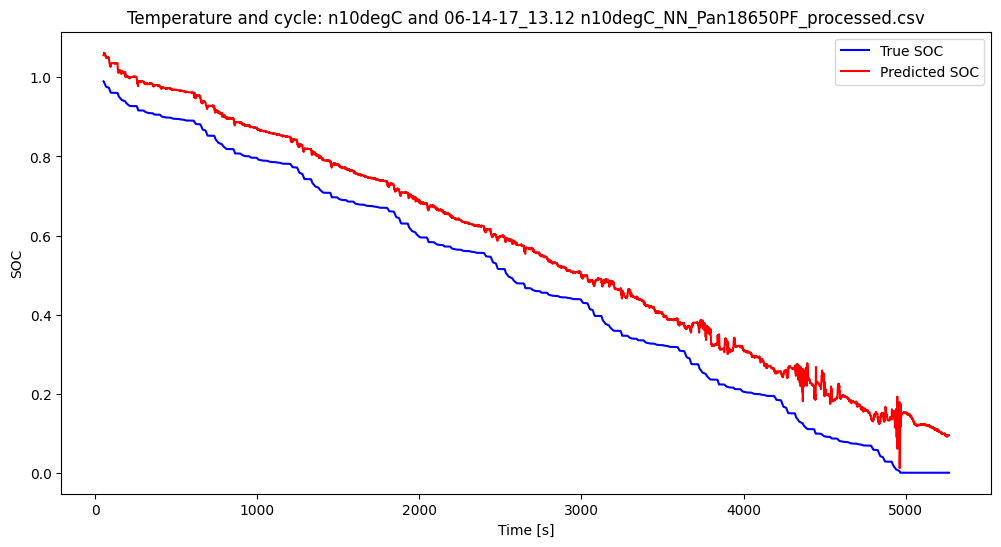


Metrics for n10degC/06-14-17_13.12 n10degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.008011
Test MAE: 0.087413
Test StdDev: 0.019249


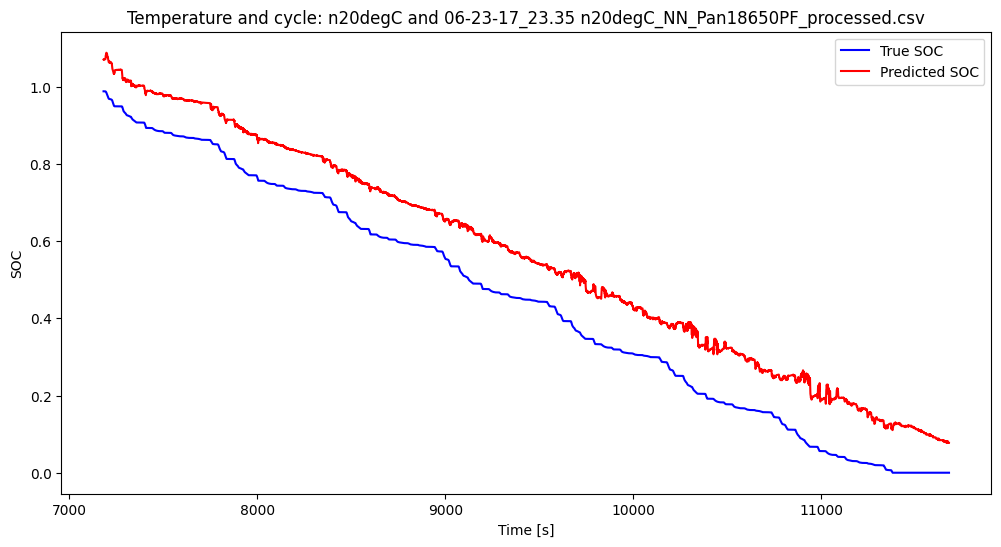


Metrics for n20degC/06-23-17_23.35 n20degC_NN_Pan18650PF_processed.csv:
Test MSE: 0.013648
Test MAE: 0.115211
Test StdDev: 0.019357


In [70]:
metrics_results = evaluate_and_plot(model, collect_data_lstm('NN'))

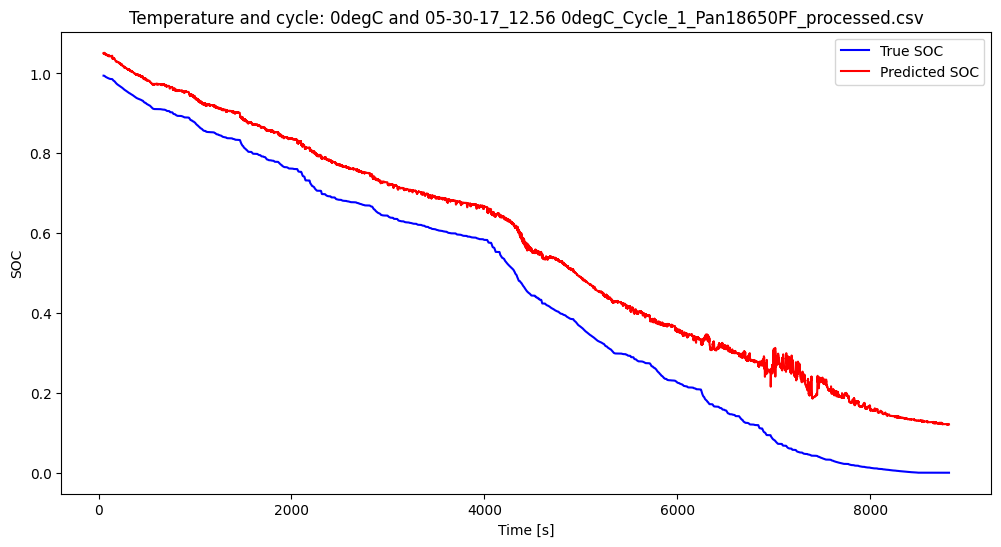


Metrics for 0degC/05-30-17_12.56 0degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.013724
Test MAE: 0.110384
Test StdDev: 0.039233


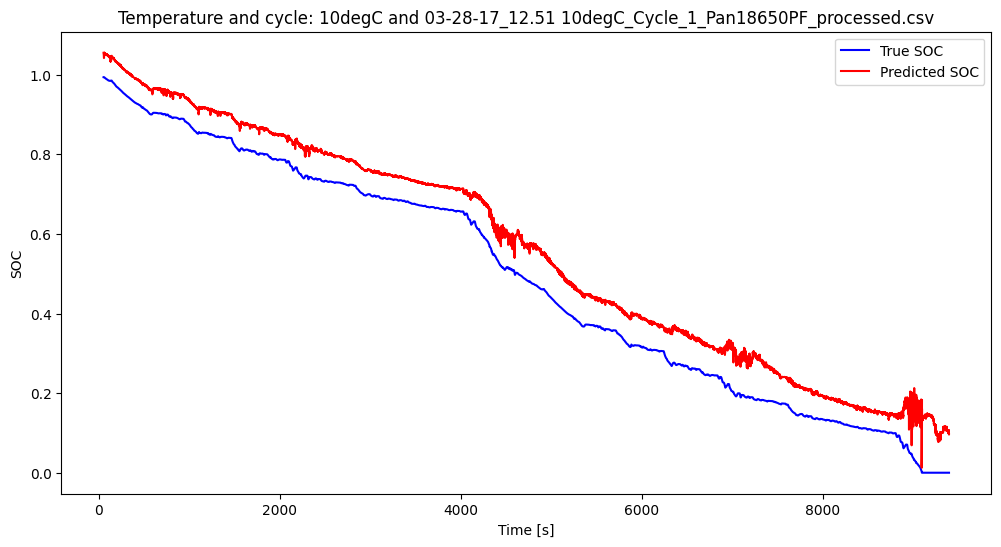


Metrics for 10degC/03-28-17_12.51 10degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.005436
Test MAE: 0.071332
Test StdDev: 0.018659


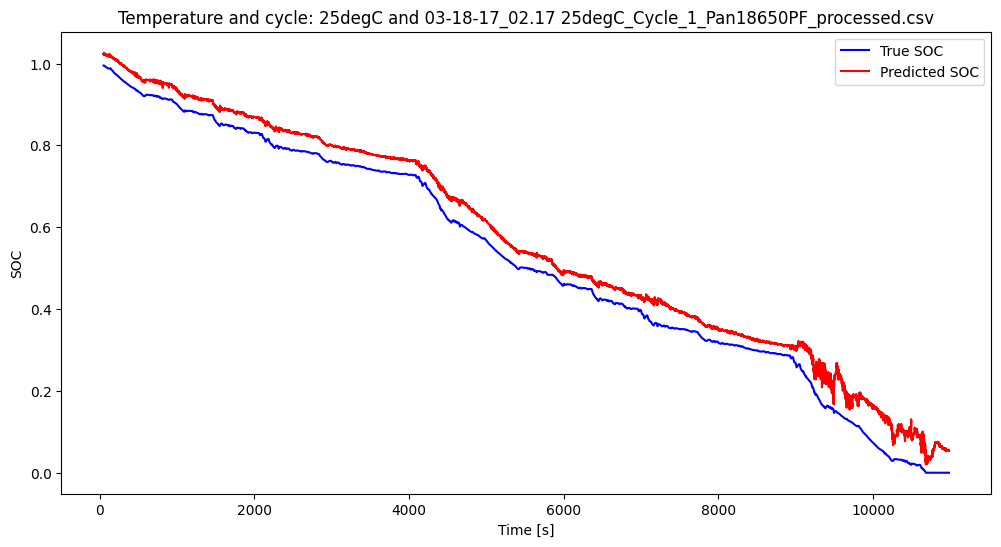


Metrics for 25degC/03-18-17_02.17 25degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.002189
Test MAE: 0.043998
Test StdDev: 0.015908


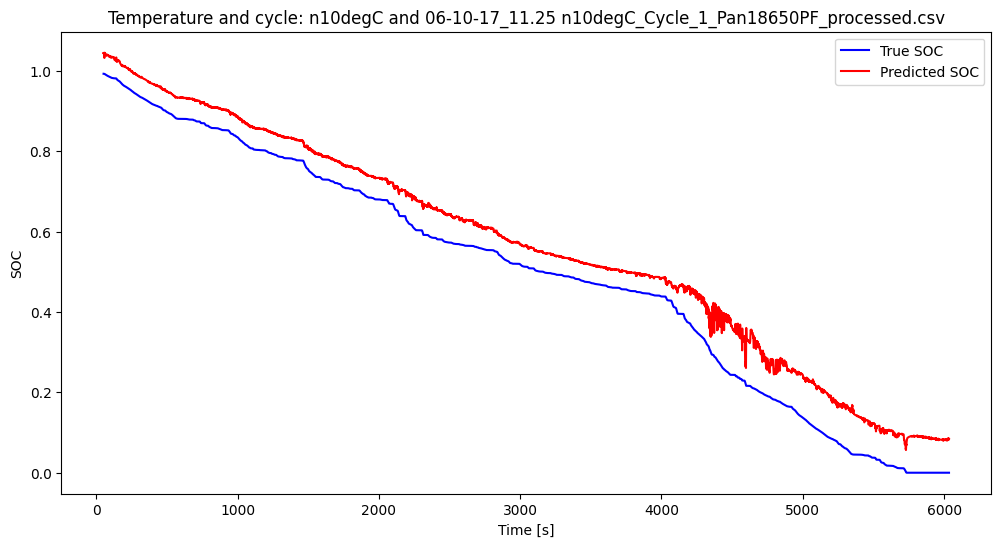


Metrics for n10degC/06-10-17_11.25 n10degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.004908
Test MAE: 0.066318
Test StdDev: 0.022575


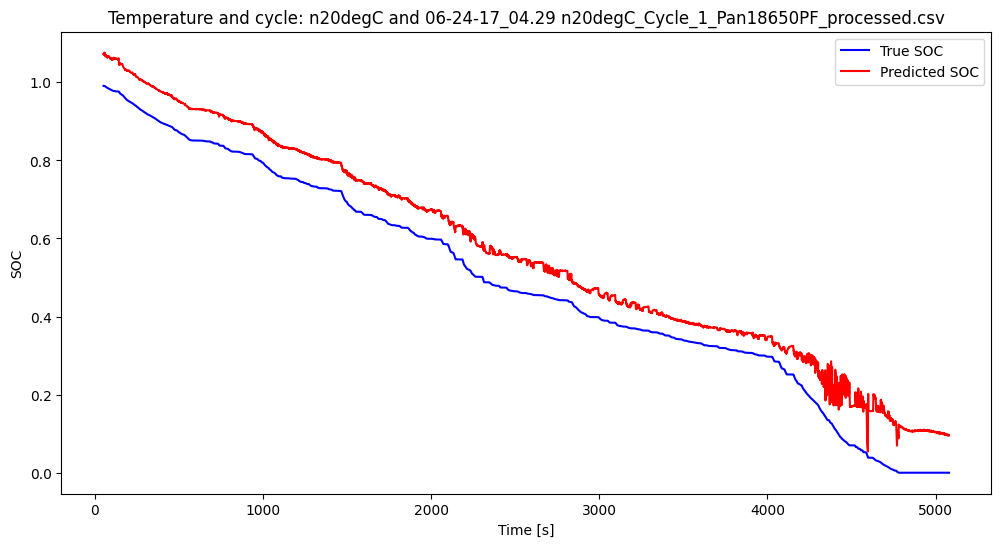


Metrics for n20degC/06-24-17_04.29 n20degC_Cycle_1_Pan18650PF_processed.csv:
Test MSE: 0.006383
Test MAE: 0.077057
Test StdDev: 0.021107


In [71]:
metrics_results = evaluate_and_plot(model, collect_data_lstm('Cycle_1'))